## Data Exploration Notebook

## Libary Imports

In [23]:
## Import necessary libraries here
import os
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from matplotlib.ticker import ScalarFormatter

In [24]:
# set the filepath to the parquet cleaned dataset
PATH = "../Data/Cleaned/Cleaned_Dataset.parquet"

# scan the parquet file with polars
scan = pl.scan_parquet(PATH)

# get the dataset schema
schema = scan.collect_schema()

## 1. General Descriptive Statistics

This section examines missing values, row and column counts, numeric descriptive statistics, and categorical descriptive statistics for the cleaned dataset.

### 1.1 Get row and column counts of the cleaned dataset

In [25]:
# get row counts
row_count = scan.select(pl.len()).collect().item()

# get column counts
col_names = schema.names()
col_count = len(col_names)

# output the row and column counts
print(f"The cleaned dataset has {row_count} rows and {col_count} columns.")

The cleaned dataset has 21005240 rows and 42 columns.


### 1.2 Column names and their respective data types

In [26]:
dtype_df = pd.DataFrame({
    "column": col_names,
    "dtype": [str(schema[name]) for name in col_names]
})

dtype_df

,column,dtype
0,Header_Length,Float32
1,Protocol_Type,Int64
2,Time_To_Live,Float32
3,Rate,Float32
4,fin_flag_number,Float32
5,syn_flag_number,Float32
6,rst_flag_number,Float32
7,psh_flag_number,Float32
8,ack_flag_number,Float32
9,ece_flag_number,Float32


### 1.3 Missing Value Analysis

In [27]:
# Missing value counts and percentages per column

# 1. Count nulls for each column
missing_count_pl = (
    scan
    .select([
        pl.col(c).null_count().alias(c)
        for c in col_names
    ])
    .collect()
    .transpose(include_header=True, header_name="feature")
)

# 2. Rename the numeric column (e.g. 'column_0') to 'missing_count'
missing_count_pl = missing_count_pl.rename({
    missing_count_pl.columns[1]: "missing_count"
})

# 3. Add missing percentage using the row_count we computed earlier
missing_pl = (
    missing_count_pl
    .with_columns(
        (pl.col("missing_count") / row_count * 100).alias("missing_pct")
    )
    .sort("missing_pct", descending=True)
)

# 4. Convert to pandas for easier viewing/plotting
missing_df = missing_pl.to_pandas()
missing_df


,feature,missing_count,missing_pct
0,Header_Length,0,0.0
1,Protocol_Type,0,0.0
2,Time_To_Live,0,0.0
3,Rate,0,0.0
4,fin_flag_number,0,0.0
5,syn_flag_number,0,0.0
6,rst_flag_number,0,0.0
7,psh_flag_number,0,0.0
8,ack_flag_number,0,0.0
9,ece_flag_number,0,0.0


Noted that there are no missing values in the cleaned dataset.

In [28]:
# establish categorical and numerical columns
categorical_cols = ["Protocol_Type", "Label", "Label_Family", "Label_Binary"]

numeric_cols = [
    name for name in col_names
    if (schema[name] in {pl.Int32, pl.Float32} and (name not in categorical_cols))
]

### 1.4 Numeric Descriptive Statistics

In [29]:
# build aggregate expressions for each numeric column
# intiitalize the empty list
agg_exprs = []

# for loop to append the aggregate expressions for each numeric column
for c in numeric_cols:
    agg_exprs.extend([
        pl.col(c).mean().alias(f"{c}_mean"),
        pl.col(c).std().alias(f"{c}_std"),
        pl.col(c).min().alias(f"{c}_min"),
        pl.col(c).quantile(0.25).alias(f"{c}_q1"),
        pl.col(c).median().alias(f"{c}_median"),
        pl.col(c).quantile(0.75).alias(f"{c}_q3"),
        pl.col(c).max().alias(f"{c}_max"),
    ])

# run a single lazy pass over the full dataset
stats_pl = scan.select(agg_exprs).collect()

# convert to pandas and reshape to a nicer format
stats_df = stats_pl.to_pandas().T
stats_df.columns = ["value"]

# reshape to a wider format
rows = []
for idx, val in stats_df["value"].items():
    feature, stat = idx.rsplit("_", 1)
    rows.append([feature, stat, val])

wide = pd.DataFrame(rows, columns=["feature", "stat", "value"])
wide_df = wide.pivot(index="feature", columns="stat", values="value")

wide_df

stat,max,mean,median,min,q1,q3,std
feature,,,,,,,
ARP,1.000000e+00,0.005679,0.000000,0.000000,0.000000,0.000000,0.027051
AVG,9.430300e+03,207.398041,60.299999,46.000000,60.000000,134.100006,315.032959
DHCP,8.000000e-01,0.000375,0.000000,0.000000,0.000000,0.000000,0.007011
DNS,1.000000e+00,0.005640,0.000000,0.000000,0.000000,0.000000,0.032201
HTTP,1.000000e+00,0.065235,0.000000,0.000000,0.000000,0.000000,0.237366
HTTPS,1.000000e+00,0.096103,0.000000,0.000000,0.000000,0.010000,0.267552
Header_Length,6.000000e+01,14.022944,19.799999,0.000000,7.920000,20.000000,9.085971
IAT,7.861200e+04,0.022037,0.000080,-0.017818,0.000038,0.000225,31.001877
ICMP,1.000000e+00,0.113021,0.000000,0.000000,0.000000,0.000000,0.308100


We note that the above numeric descriptive statistics dataframe is revealing especially identifying that there is a minimum value for the feature IAT of -0.01781797967851162. This says that there are packets which are arriving before the next packet and is not an artifact of actual network traffic. This will have to be readjusted to clamp negative values to zero or left as is. This occurs as a result of packet capture timestamp jitter which is aknown limitation of CICFlowMeter.

### 1.5 Categorical Descriptive Statistics


In [30]:
# initialize empty categorical summary dictionary
categorical_summary = {}

# for loop to compute value counts for each categorical column
categorical_summary = {}

# for loop to compute value counts for each categorical column
for col in categorical_cols:
    # Compute full value counts for the column using lazy evaluation
    value_counts_df = (
        scan
        .group_by(col)
        .len()
        .sort("len", descending=True)
        .collect()
        .to_pandas()
        .rename(columns={"len": "count"})
    )

    total = value_counts_df["count"].sum()
    value_counts_df["pct"] = value_counts_df["count"] / total * 100

    categorical_summary[col] = value_counts_df

# Break out into one DataFrame per categorical column
protocol_type_summary_df = categorical_summary["Protocol_Type"].copy()
label_summary_df         = categorical_summary["Label"].copy()
label_family_summary_df  = categorical_summary["Label_Family"].copy()
label_binary_summary_df  = categorical_summary["Label_Binary"].copy()

# View the categorical dataframes
display(protocol_type_summary_df)
display(label_summary_df)
display(label_family_summary_df)
display(label_binary_summary_df)

,Protocol_Type,count,pct
0,6,11895074,56.629079
1,17,5185084,24.684717
2,1,2333806,11.110590
3,47,1577931,7.512083
4,0,13342,0.063517
5,2,3,0.000014


,Label,count,pct
0,DDOS-UDP_FLOOD,1964164,9.350829
1,DDOS-ICMP_FLOOD,1907561,9.081358
2,DOS-UDP_FLOOD,1851682,8.815334
3,DDOS-SYN_FLOOD,1764599,8.400756
4,DDOS-PSHACK_FLOOD,1641898,7.816611
5,DDOS-TCP_FLOOD,1560619,7.429665
6,DDOS-RSTFINFLOOD,1255787,5.978446
7,DDOS-SYNONYMOUSIP_FLOOD,1171378,5.576599
8,DOS-SYN_FLOOD,1138614,5.420619
9,DOS-TCP_FLOOD,1120182,5.332869


,Label_Family,count,pct
0,DDOS,12292078,58.519103
1,DOS,4178919,19.894650
2,MIRAI,2359183,11.231402
3,BENIGN,1047308,4.985937
4,RECON,655464,3.120479
5,SPOOFING,436061,2.075963
6,WEB,23707,0.112862
7,BRUTE_FORCE,12520,0.059604


,Label_Binary,count,pct
0,1,19957932,95.014063
1,0,1047308,4.985937


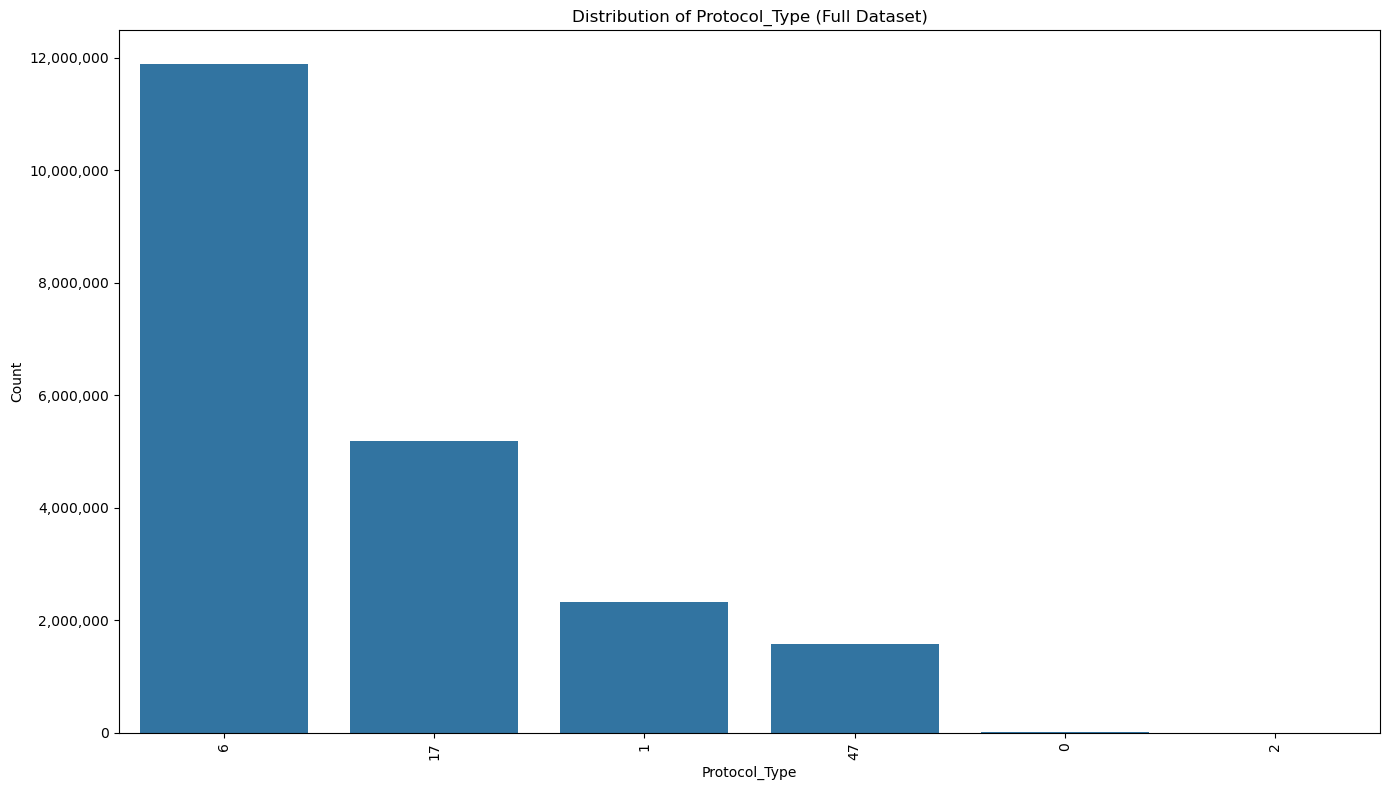

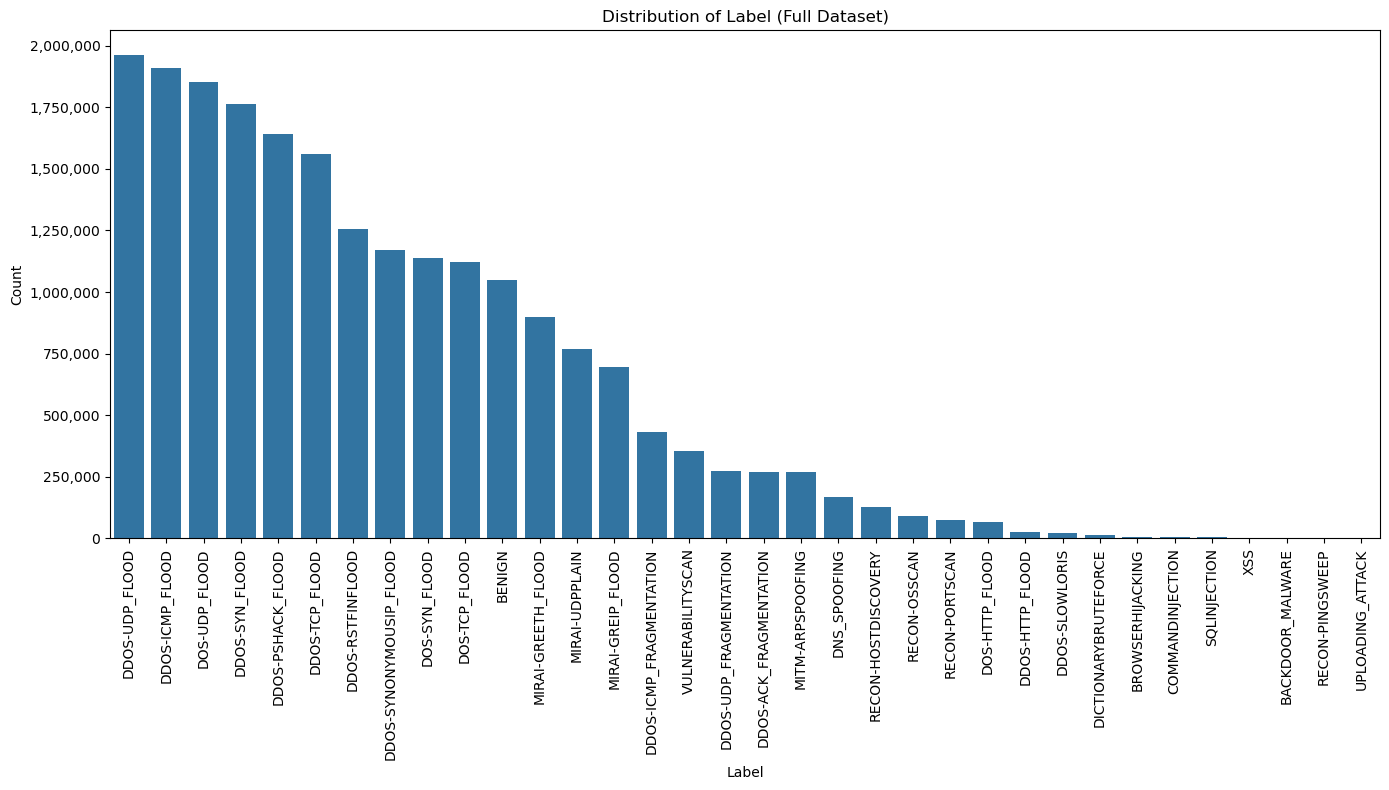

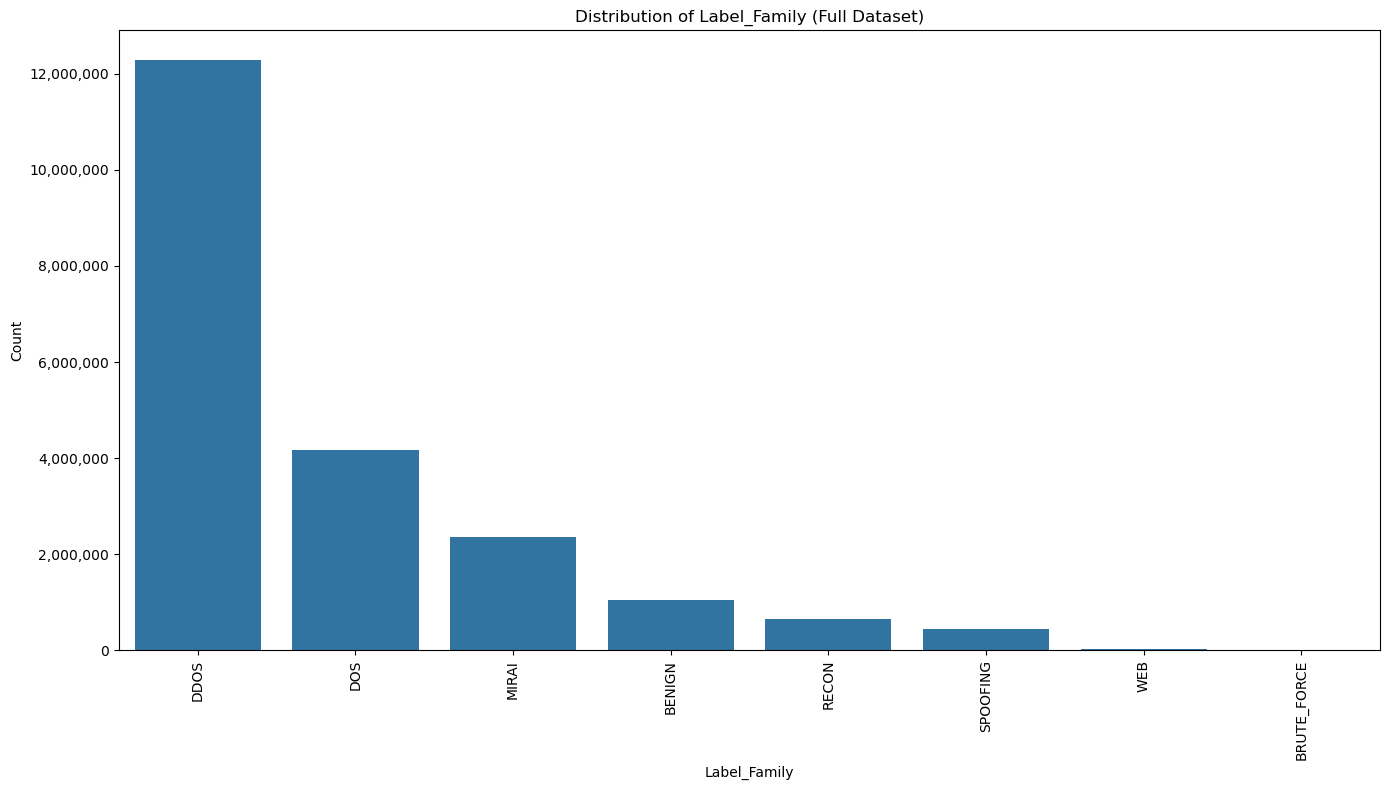

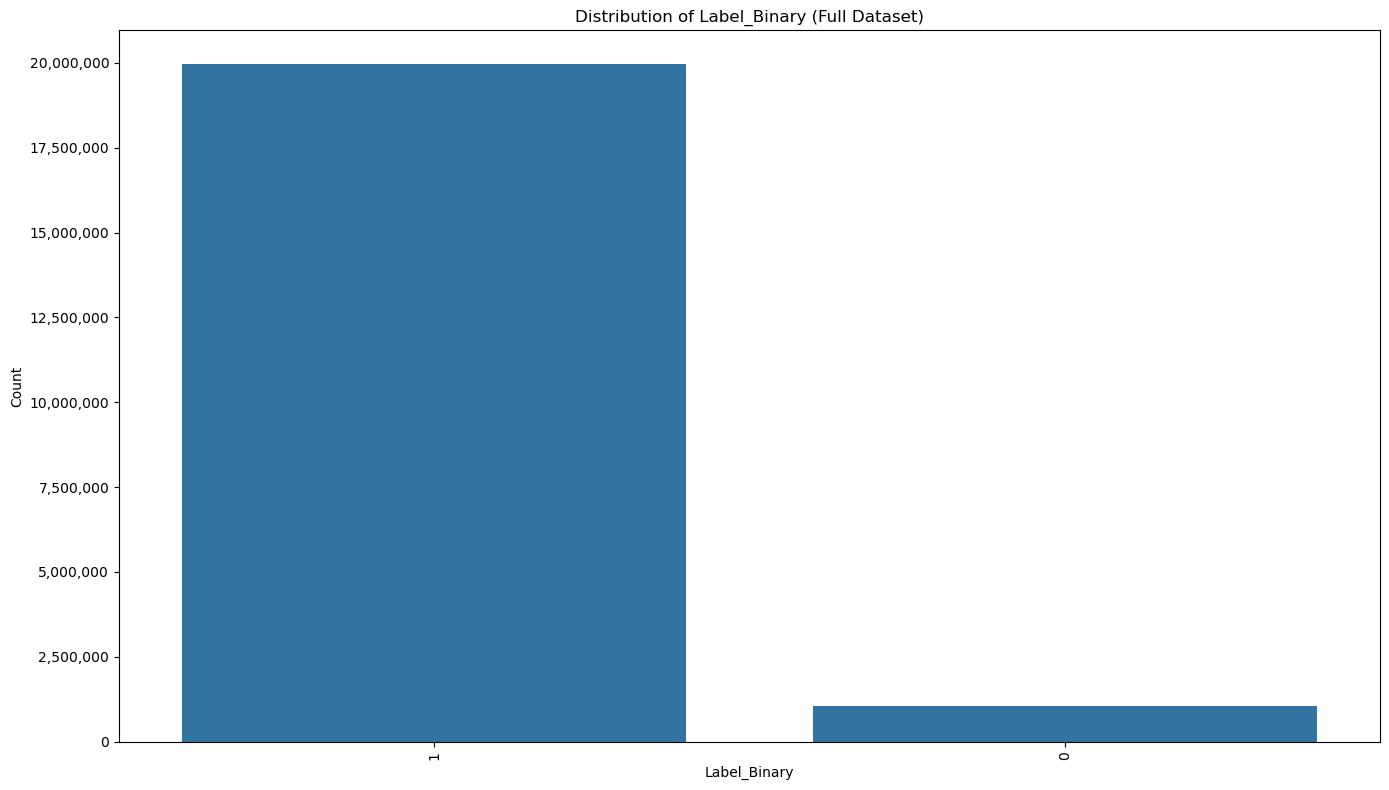

In [31]:
for col in categorical_cols:
    # Get the precomputed summary for this column
    value_counts_df = categorical_summary[col].copy() 
    plt.figure(figsize=(14, 8))
    # Preserve the descending-count order from value_counts_df
    ax = sns.barplot(
        data=value_counts_df,
        x=col,
        y="count",
        order=value_counts_df[col].tolist()
    )
    # Rotate x labels vertically for readability
    plt.xticks(rotation=90)
    # Format y-axis with comma separators
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plt.title(f"Distribution of {col} (Full Dataset)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

## 2. Univariate Analysis

In [32]:
# Build our helper histogram function leveraging polars lazy computation
def full_histogram(scan, column: str, bins: int = 50):
    """
    Compute histogram bins for a numeric column using the full dataset 
    (lazy Polars computation), returning a small pandas DataFrame with:
    - bin_mid
    - count
    """
    # Compute min/max for the full column
    min_max = scan.select([
        pl.col(column).min().alias("min"),
        pl.col(column).max().alias("max")
    ]).collect()

    col_min = float(min_max["min"][0])
    col_max = float(min_max["max"][0])

    # avoid invalid bins
    if not np.isfinite(col_min) or not np.isfinite(col_max) or col_min == col_max:
        return pd.DataFrame({"bin_mid": [], "count": []})

    # Build bin edges
    edges = np.linspace(col_min, col_max, bins + 1)

    # Cut into bins & count frequencies
    hist_df = (
        scan
        .with_columns([
            pl.col(column).cut(breaks=edges).alias("bin")
        ])
        .group_by("bin")
        .len()
        .sort("bin")
        .collect()
        .to_pandas()
        .rename(columns={"len": "count"})
    )

    # Compute bin midpoints
    mids = []
    for b in hist_df["bin"]:
        # Format: "[a, b)"
        s = str(b).strip("[]()")
        left, right = s.split(",")
        mids.append((float(left), float(right)))

    hist_df["bin_mid"] = [(l + r) / 2 for (l, r) in mids]

    return hist_df[["bin_mid", "count"]]

def plot_univariate_numeric(column: str, bins: int = 50):
    """
    Plot the univariate distribution of a numeric feature using a fully 
    memory-safe histogram computed over the entire dataset.

    Parameters
    ----------
    column : str
        Name of the numeric column to visualize.
    bins : int, default=50
        Number of histogram bins used when aggregating the feature.

    Description
    -----------
    This function visualizes the distribution of a numeric variable by using 
    `full_histogram()`, which computes bin counts lazily with Polars. Unlike 
    traditional histogram plotting approaches that require loading the entire 
    column into memory, this method performs aggregation at the Polars 
    LazyFrame level, making it safe to use on very large datasets (e.g., 
    20+ million rows).

    The returned histogram is a small, aggregated DataFrame containing:
        - bin_mid : midpoint of each histogram bin
        - count   : number of observations falling within each bin

    These aggregated results are then plotted using seaborn for a clean, 
    readable visualization of the full distribution.
    """
    hist_df = full_histogram(scan, column, bins=bins)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=hist_df, x="bin_mid", y="count", color="steelblue")

    plt.title(f"Distribution of {column} (Full Dataset)")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

### 2.1 Skewness of Numeric Features

In [33]:
# Extract random 200,000 observation sample for skewness analysis
SKEW_SAMPLE_N = 200_000
# chunk this to keep memory small
CHUNK_SIZE = 100_000

rng = np.random.default_rng(42)
collected = []

start = 0

# Loop until we collect 200k total rows
while sum(len(df) for df in collected) < SKEW_SAMPLE_N:
    chunk = (
        scan
        .slice(start, CHUNK_SIZE)
        .select(numeric_cols)
        .collect()
        .to_pandas()
    )
    
    # If no more rows, break (failsafe)
    if chunk.empty:
        break

    # Randomly choose ~30% of each chunk
    sampled = chunk.sample(frac=0.3, random_state=rng.integers(0, 1e9))
    collected.append(sampled)

    start += CHUNK_SIZE

# Concatenate all chunk samples
sample_df = pd.concat(collected, ignore_index=True)

# Final trim down to perfect 200,000
if len(sample_df) > SKEW_SAMPLE_N:
    sample_df = sample_df.sample(n=SKEW_SAMPLE_N, random_state=42)

print("Final sample size:", len(sample_df))
sample_df.head()

Final sample size: 200000


,Header_Length,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,...,LLC,Tot_sum,Min,Max,AVG,Std,Tot_size,IAT,Number,Variance
194949,19.879999,67.820000,12724.278320,0.0,0.00,0.01,0.98,0.99,0.0,0.0,...,1.00,6013,60,73,60.130001,1.300000,60.130001,0.000079,100,1.690000
161875,19.680000,62.759998,49902.488281,0.0,0.98,0.00,0.00,0.00,0.0,0.0,...,0.99,6099,60,159,60.990002,9.900000,60.990002,0.000020,100,98.010002
61912,8.480000,65.690002,48805.027344,0.0,0.00,0.00,0.00,0.02,0.0,0.0,...,1.00,6012,60,66,60.119999,0.844232,60.119999,0.000021,100,0.712727
35966,0.000000,64.000000,10998.568359,0.0,0.00,0.00,0.00,0.00,0.0,0.0,...,1.00,59200,592,592,592.000000,0.000000,592.000000,0.000092,100,0.000000
143596,0.000000,64.000000,29576.927734,0.0,0.00,0.00,0.00,0.00,0.0,0.0,...,1.00,6000,60,60,60.000000,0.000000,60.000000,0.000152,100,0.000000


In [34]:
# compute skewness dataframe

skewness_series = sample_df.skew(numeric_only=True)

# build skewness dataframe
skewness_df = (
    skewness_series
    .sort_values(ascending=False)
    .to_frame(name="skewness")
)

# compute absolute skewness for ordering
skewness_df["abs_skew"] = skewness_df["skewness"].abs()

# sort by absolute skew (most skewed first)
skewness_df = skewness_df.sort_values("abs_skew", ascending=False)

skewness_df

,skewness,abs_skew
SMTP,388.174255,388.174255
IAT,262.795197,262.795197
Telnet,114.589912,114.589912
cwr_flag_number,85.442062,85.442062
ece_flag_number,83.276260,83.276260
IRC,73.323410,73.323410
IGMP,64.614799,64.614799
SSH,48.727009,48.727009
DHCP,32.768654,32.768654
Variance,30.026117,30.026117



Processing feature: SMTP


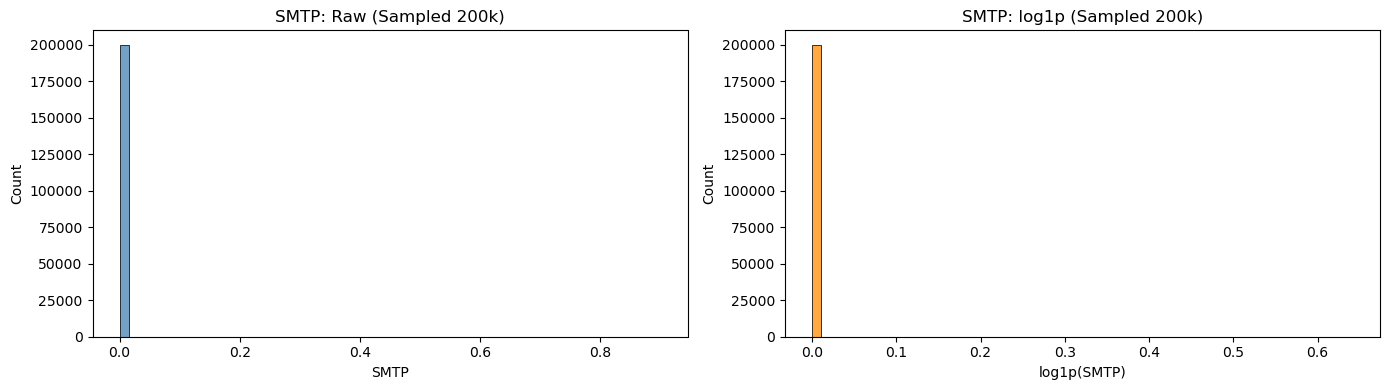


Processing feature: IAT


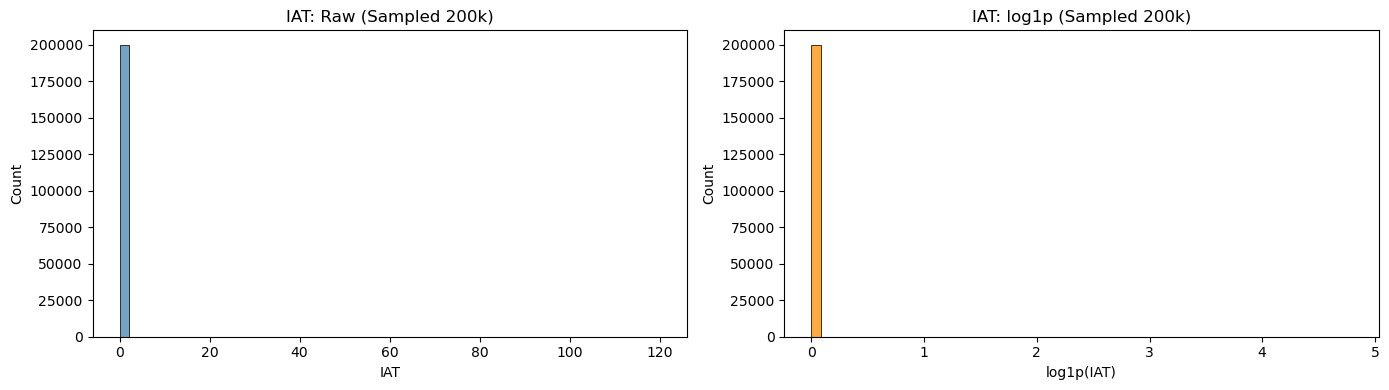


Processing feature: Telnet


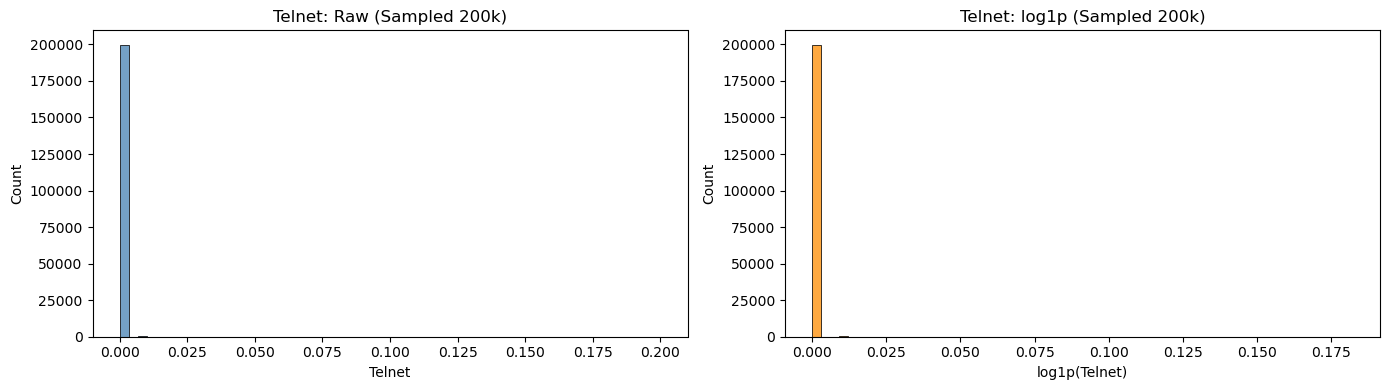


Processing feature: cwr_flag_number


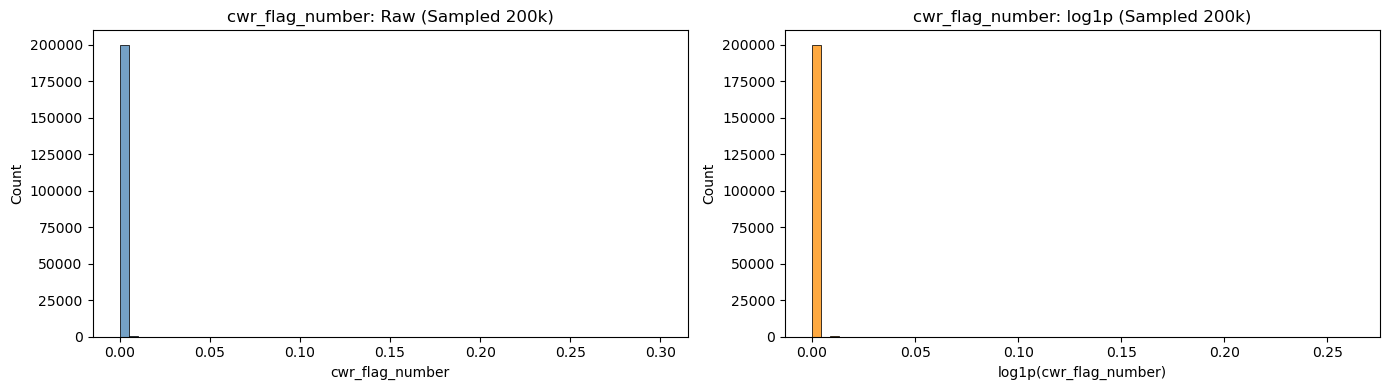


Processing feature: ece_flag_number


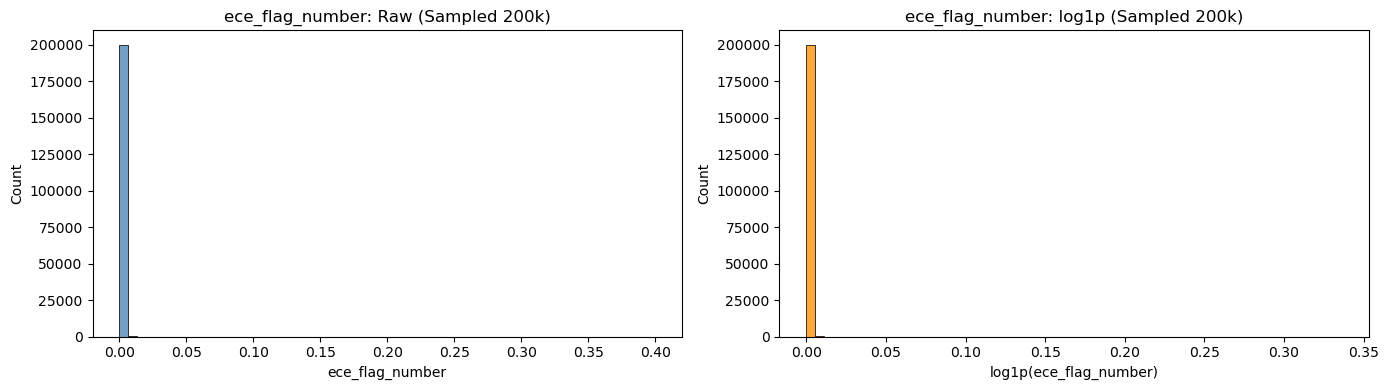


Processing feature: IRC


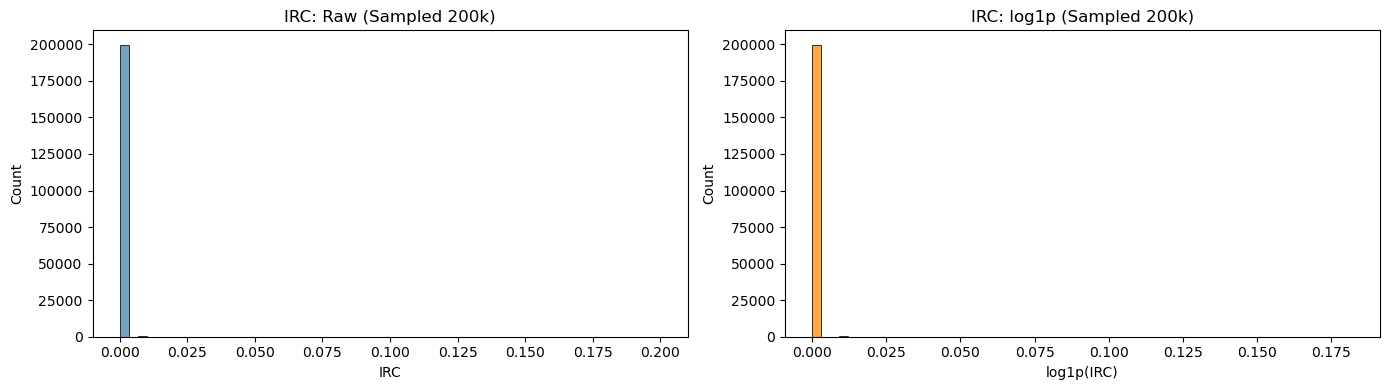

In [35]:
# Select the top 6 most skewed features
top_skewed_features = skewness_df.index.tolist()[:6]

for col in top_skewed_features:
    print(f"\nProcessing feature: {col}")

    # Use the existing 200,000 sample_df
    raw_vals = sample_df[col].dropna()

    # Log1p transform
    log_vals = np.log1p(raw_vals)

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # RAW
    sns.histplot(raw_vals, bins=60, ax=axes[0], color="steelblue")
    axes[0].set_title(f"{col}: Raw (Sampled 200k)")
    axes[0].set_xlabel(col)

    # LOG
    sns.histplot(log_vals, bins=60, ax=axes[1], color="darkorange")
    axes[1].set_title(f"{col}: log1p (Sampled 200k)")
    axes[1].set_xlabel(f"log1p({col})")

    plt.tight_layout()
    plt.show()

#### Interpreting the Univariate Distributions for Highly Skewed Features

The raw and log-transformed histograms for highly skewed numeric features (e.g., `IAT`, `Telnet`, `SMTP`, `IRC`, `ece_flag_num`, `cwr_flag_num`) appear dominated by a single bar. Although not visually rich, these plots reveal **critical characteristics** of the dataset.

---

##### 1. Extreme Sparsity in Network Flow Features
Across all highly skewed variables, **over 99% of values are zero or extremely close to zero**. This is typical in IoT network telemetry:

- Most flows never trigger certain protocols or flags.  
- Inter-arrival times (e.g., `IAT`) are often 0.  
- Protocol counters (`SMTP`, `Telnet`, `IRC`, etc.) are rarely activated.  

As a result, the first histogram bin (containing near-zero values) captures almost the entire dataset.

---

##### 2. The Dominant Zero Bin
Because nearly all values lie at or near zero, the leftmost bin completely dominates the histogram. This causes:

- All other bins to appear empty  
- The distribution to visually collapse into a single spike  
- Very large differences between the dominant bin and the tail  

This is a **true reflection of the data**, not a plotting issue.

---
    
##### 3. Why Log Transform Doesn't Change the Shape Much
The log transform helps with long-tailed data, but:

- `log1p(0) = 0`  
- When 99%+ of values are zero, log1p still leaves the same dominant zero spike  
- Only the very small fraction of high outliers shift position  

Thus, the log1p histogram remains dominated by a single bar.

---

##### 4. These Features Behave Like Sparse Event Counters
Instead of behaving like continuous numeric variables, these columns function more like:

- **event indicators** (presence vs absence)  
- **anomaly spikes**  
- **rare protocol activations**  

This makes traditional histograms less informative.

---

##### 5. Better Approaches for Understanding These Features
Given the extreme sparsity, more meaningful summaries include:

- Zero vs non-zero counts  
- Percentile tables (p50, p90, p95, p99, p99.9, max)  
- Log-scale boxplots  
- Distributions of **non-zero** values only  
- Comparing distributions across the `Label` column (malicious vs benign)

These provide clearer insight into how these features behave in relation to attack detection.

---

##### Conclusion for skewness analysis
Although the histograms appear visually simple, they accurately reflect that these features are **highly sparse, zero-dominated, and spike-driven**—a common pattern in IoT network traffic data. Understanding this structure is essential for guiding appropriate feature engineering and model selection in downstream analysis.


### 2.2 Zero vs. Non-Zero Value Analysis

In [36]:
zero_nonzero_stats = []

for col in numeric_cols:
    # Compute zero count and non-zero count lazily
    result = (
        scan
        .select([
            (pl.col(col) == 0).sum().alias("zero_count"),
            (pl.col(col) != 0).sum().alias("nonzero_count")
        ])
        .collect()
    )

    zero_count = int(result["zero_count"][0])
    nonzero_count = int(result["nonzero_count"][0])
    total = zero_count + nonzero_count

    zero_nonzero_stats.append({
        "feature": col,
        "zero_count": zero_count,
        "nonzero_count": nonzero_count,
        "pct_nonzero": nonzero_count / total * 100
    })

# Convert to DataFrame
zero_nonzero_df = pd.DataFrame(zero_nonzero_stats)

# Sort by non-zero percentage (descending)
zero_nonzero_df = zero_nonzero_df.sort_values("pct_nonzero", ascending=False)

zero_nonzero_df

,feature,zero_count,nonzero_count,pct_nonzero
2,Rate,0,21005240,100.000000
36,Number,0,21005240,100.000000
35,IAT,0,21005240,100.000000
34,Tot_size,0,21005240,100.000000
32,AVG,0,21005240,100.000000
31,Max,0,21005240,100.000000
30,Min,0,21005240,100.000000
29,Tot_sum,0,21005240,100.000000
1,Time_To_Live,452,21004788,99.997848
28,LLC,452,21004788,99.997848


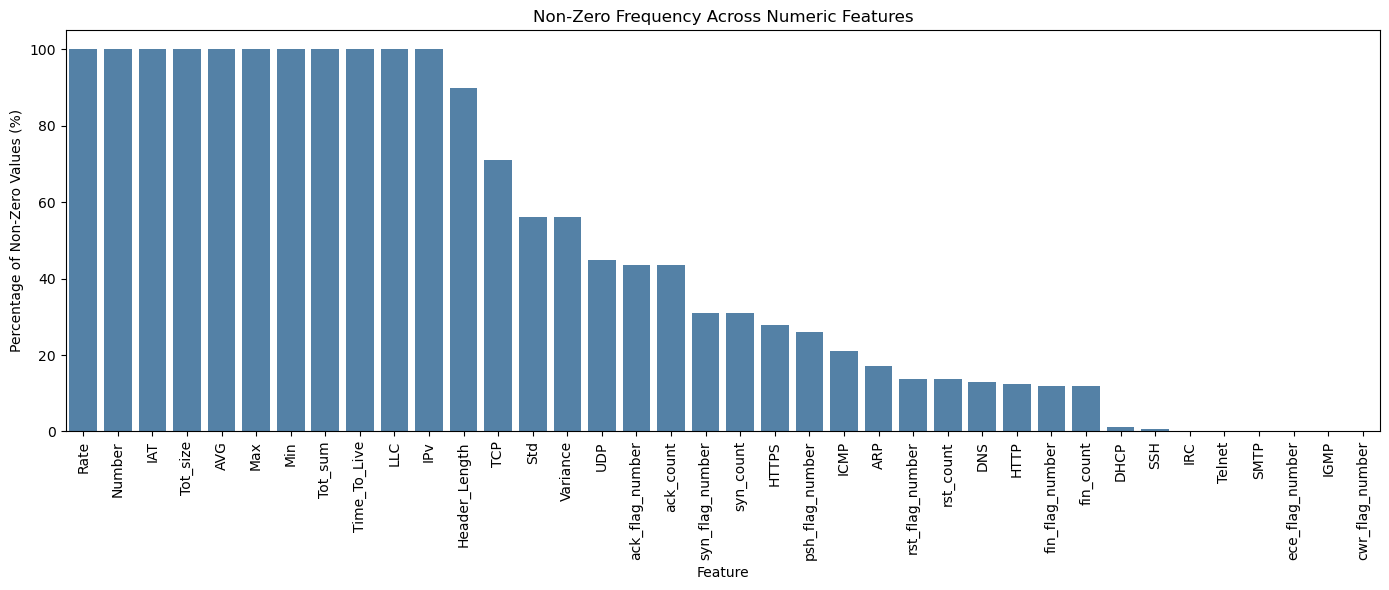

In [37]:
# visualization of zero vs. non-zero features
plt.figure(figsize=(14, 6))
sns.barplot(
    data=zero_nonzero_df,
    x="feature",
    y="pct_nonzero",
    color="steelblue"
)

plt.xticks(rotation=90)
plt.ylabel("Percentage of Non-Zero Values (%)")
plt.xlabel("Feature")
plt.title("Non-Zero Frequency Across Numeric Features")
plt.tight_layout()
plt.show()

#### Zero vs Non-Zero Analysis Summary

To better understand sparsity patterns in the dataset, we evaluated the percentage of zero and non-zero values for every numeric feature. This revealed several important structural properties of the network traffic:

---

##### 1. Dense Features (≈ 100% Non-Zero)
Features such as `Rate`, `Number`, `IAT`, `Tot_size`, `AVG`, `Max`, `Min`, and `Tot_sum` show **no zero values at all**.  
These represent continuous traffic characteristics (packet counts, sizes, timing aggregates) and exhibit normal numeric behavior suitable for standard scaling and transformation techniques.

---

##### 2. Moderately Sparse Features (10%–60% Non-Zero)
Features like `TCP`, `UDP`, `Std`, `Variance`, `ack_count`, `syn_count`, `psh_flag_number`, and `ICMP` contain a mix of zero and non-zero values.  
These features likely capture protocol activity or flow behavior that occurs intermittently.  
They may exhibit long-tailed or bursty patterns that require log-scale analysis or special consideration during feature engineering.

---

##### 3. Highly Sparse Features (< 5% Non-Zero)
Protocol-specific and flag-specific counters (e.g., `SSH`, `IRC`, `Telnet`, `SMTP`, `IGMP`, `ece_flag_number`, `cwr_flag_number`) are **almost always zero**, with non-zero rates below 1%.  
This sparsity is expected in IoT network traffic: most flows do not activate these protocols or flags.  
These features behave more like **binary indicators** of rare events rather than continuous numeric variables.

---

##### Key Insight
The presence of both dense and highly sparse numeric features suggests a mixture of:

- **continuous traffic descriptors**  
- **event-driven anomaly counters**  
- **rare protocol activations**

This explains why raw and log-transformed histograms often collapsed into a single bar: the distributions are dominated by near-zero values.  
Understanding this sparsity structure is essential for selecting appropriate transformations, feature encodings, and downstream modeling strategies.

---

##### Next Steps
To complete the univariate numeric analysis, we will generate **percentile summary tables (p50–p99.9)** for each feature.  
This will help characterize tail behavior, scale differences, and outlier severity across the dataset.


### 2.3 Percentile Summary Table

In [38]:
percentiles = [0.50, 0.90, 0.95, 0.99, 0.999]

summary_rows = []

for col in numeric_cols:
    # Compute stats lazily
    result = (
        scan
        .select([
            pl.col(col).min().alias("min"),
            pl.col(col).max().alias("max"),
            *[
                pl.col(col).quantile(q, "nearest").alias(f"p{int(q*1000)/10}")
                for q in percentiles
            ]
        ])
        .collect()
    )

    row = {"feature": col}
    for key in result.columns:
        row[key] = float(result[key][0])
    
    summary_rows.append(row)

percentile_df = pd.DataFrame(summary_rows)

# Order columns nicely
ordered_cols = ["feature", "min", "p50.0", "p90.0", "p95.0", "p99.0", "p99.9", "max"]
percentile_df = percentile_df[ordered_cols]

# Sort by tail severity (p99.9 - median)
percentile_df["tail_spread"] = percentile_df["p99.9"] - percentile_df["p50.0"]
percentile_df = percentile_df.sort_values("tail_spread", ascending=False)

percentile_df

,feature,min,p50.0,p90.0,p95.0,p99.0,p99.9,max,tail_spread
37,Variance,0.000000,1.960000,89047.609375,352569.906250,1.253776e+06,6.989014e+06,1.358485e+08,6.989012e+06
2,Rate,0.000013,12682.341797,41651.480469,51896.855469,1.071890e+05,3.039351e+05,1.572864e+07,2.912527e+05
29,Tot_sum,120.000000,6014.000000,57345.000000,59200.000000,9.364400e+04,1.026900e+05,3.164920e+05,9.667600e+04
31,Max,46.000000,78.000000,1500.000000,1514.000000,3.492000e+03,8.754000e+03,5.219400e+04,8.676000e+03
33,Std,0.000000,1.400000,298.408447,593.776001,1.119721e+03,2.643674e+03,1.165540e+04,2.642274e+03
34,Tot_size,46.000000,60.299999,587.479980,908.130005,1.452200e+03,2.529500e+03,9.430300e+03,2.469200e+03
32,AVG,46.000000,60.299999,587.479980,908.130005,1.452200e+03,2.529500e+03,9.430300e+03,2.469200e+03
30,Min,42.000000,60.000000,75.000000,554.000000,5.920000e+02,1.514000e+03,7.306000e+03,1.454000e+03
1,Time_To_Live,0.000000,64.000000,71.699997,99.019997,1.837000e+02,2.456000e+02,2.550000e+02,1.816000e+02
13,rst_count,0.000000,0.000000,5.000000,99.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02


#### Percentile Summary Table: Interpretation of Numeric Feature Distributions

To better understand the distributional structure of numeric features—especially those exhibiting heavy tails or extreme sparsity—we computed detailed percentile statistics (p50 → p99.9) for every numeric column. This analysis provides critical insight into feature scale, tail behavior, and the presence of rare but extreme values commonly found in network intrusion datasets.

---

##### 1. Strong Long-Tail Behavior in Continuous Traffic Features
Features such as `Variance`, `Rate`, `Std`, `Tot_sum`, `Min`, and `Max` exhibit **very large differences** between the median (p50) and extreme percentiles (p99 and p99.9).  

For example:

- **Variance**: p50 ≈ 1.96 → p99.9 ≈ 1,253,775  
- **Rate**: p50 ≈ 12,682 → p99.9 ≈ 303,935  
- **Std**: p50 ≈ 1.40 → p99.9 ≈ 2,643  

These extremely heavy-tailed distributions are expected in high-volume IoT network flows and indicate that a small fraction of connections exhibit dramatically different behavior compared to the majority.  
Such variables may benefit from **log transformation**, **robust scaling**, or **winsorization** when used in models sensitive to outliers.

---

##### 2. Dense but Highly Variable Aggregation Features
Aggregated size and timing metrics such as `Tot_size`, `AVG`, `Time_To_Live`, and `Header_Length` show:

- high percentages of non-zero values  
- moderate to strong increases from p50 to p99.9  
- typical behavior for continuous packet-level metrics  

These features are likely **important predictors** due to their broad distribution and variability across flows.

---

##### 3. Sparse Event Counters and Protocol Indicators
Many protocol or flag-based features (e.g., `ack_count`, `syn_count`, `psh_flag_number`, `UDP`, `ICMP`) show:

- **min = p50 = 0**  
- small increases by p90/p95  
- sharp jumps at p99 or p99.9  

This pattern indicates **rare but meaningful spikes**, which align with anomalous or malicious behaviors.  
For example:

- `ack_count`: p50 = 0 → p99.9 = 100  
- `UDP`: p50 = 0 → p99.9 = 2  

Even small non-zero values may signal specific types of attacks or protocol misuse.

---
##### 4. Nearly Binary Features (0 Almost Everywhere)
Some features (e.g., `SSH`, `IRC`, `Telnet`, `SMTP`, `IGMP`, `cwr_flag_number`, `ece_flag_number`) remain zero through almost all percentiles, only rising at p99 or p99.9.

These essentially behave as **binary indicators**:

- 0 = no activity  
- >0 = rare protocol activation (often associated with attack traffic)

Given their extremely low frequency of non-zero values, these features may be more effective when converted to:

- `"is_nonzero"` binary flags  
- rare-event indicators  
- or categorical representations

rather than treated as continuous numeric variables.

---

##### Key Insights
The percentile analysis confirms that the dataset contains a mix of:

- **dense continuous features** with long-tailed variability  
- **sparse but informative event counters**  
- **protocol usage indicators** where even small non-zero spikes carry semantic meaning  

This combination reflects the heterogeneous nature of IoT network flows and highlights the importance of:

- robust scaling methods  
- careful handling of sparse features  
- binary feature engineering  
- and awareness of extreme values in downstream modeling.

---

##### Next Steps
With univariate numeric analysis complete, we can now transition into **Bivariate Analysis**, examining how these features relate to the target `Label` and to each other. This will deepen our understanding of which numeric signals most strongly differentiate benign and malicious network activity.


## 3. Bivariate Analysis

The goal of our Bivariate Analysis section is two-fold.

1. Assess relationships between numeric features and the target `Label` (different attack types vs benign) to identify strong predictors.
2. How do numeric and catefgorical features relate to one another?

### 3.1 Numeric Features vs. Target Label

#### 3.1.1 Percent Non-Zero Activation by Label

Does this numeric feature activate more often in attacks traffic compared to benign traffic?

In [39]:
pct_nonzero_label_rows = []

for col in numeric_cols:
    result = (
        scan
        .group_by("Label")
        .agg([
            (pl.col(col) != 0).sum().alias("nonzero_count"),
            pl.len().alias("total_count")
        ])
        .with_columns(
            (pl.col("nonzero_count") / pl.col("total_count") * 100.0)
            .alias("pct_nonzero")
        )
        .collect()
        .to_pandas()
    )

    result["feature"] = col
    pct_nonzero_label_rows.append(result)

pct_nonzero_label_df = pd.concat(pct_nonzero_label_rows, ignore_index=True)

# Reorder columns
pct_nonzero_label_df = pct_nonzero_label_df[
    ["feature", "Label", "nonzero_count", "total_count", "pct_nonzero"]
]

pct_nonzero_label_df

,feature,Label,nonzero_count,total_count,pct_nonzero
0,Header_Length,DDOS-UDP_FLOOD,1964160,1964164,99.999796
1,Header_Length,BACKDOOR_MALWARE,3075,3075,100.000000
2,Header_Length,DOS-SYN_FLOOD,1138614,1138614,100.000000
3,Header_Length,DICTIONARYBRUTEFORCE,12520,12520,100.000000
4,Header_Length,MIRAI-UDPPLAIN,767297,767297,100.000000
...,...,...,...,...,...
1287,Variance,DNS_SPOOFING,156159,167017,93.498865
1288,Variance,DDOS-UDP_FRAGMENTATION,273390,273392,99.999268
1289,Variance,DDOS-RSTFINFLOOD,467612,1255787,37.236570
1290,Variance,MIRAI-GREETH_FLOOD,527640,897596,58.783684


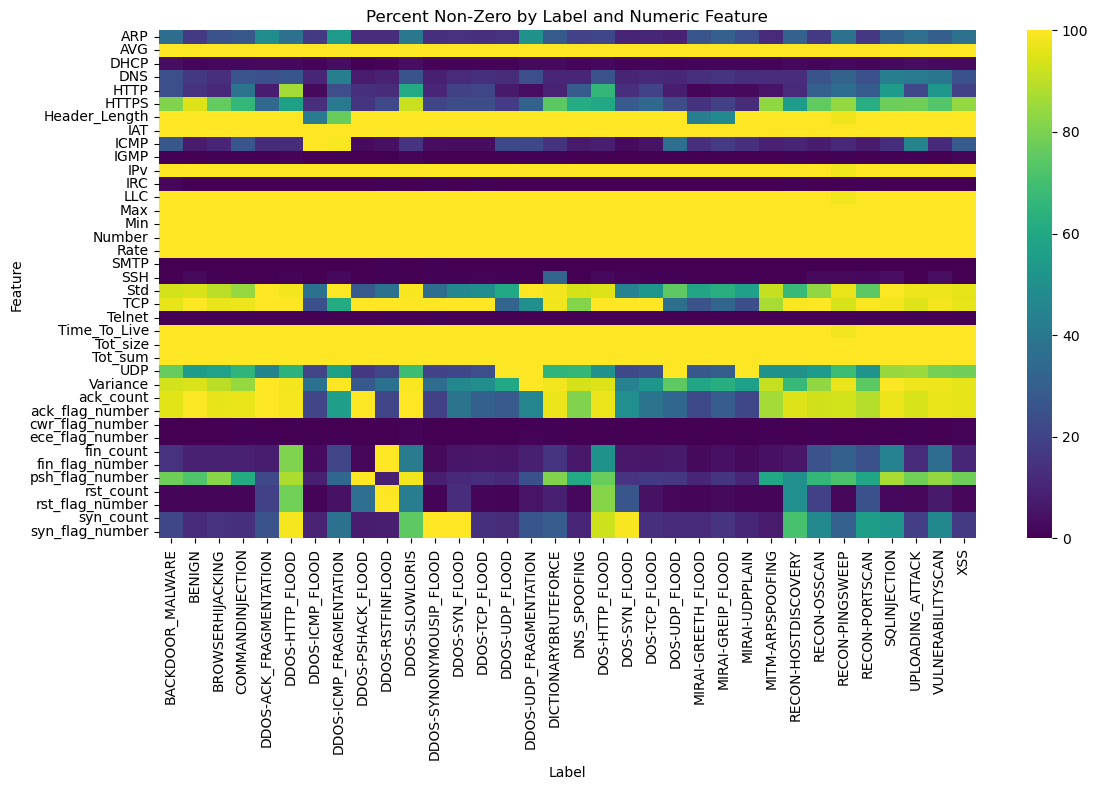

In [40]:
# heatmap visualization of non-zero percentages by label
heatmap_df = pct_nonzero_label_df.pivot(
    index="feature",
    columns="Label",
    values="pct_nonzero"
)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, cmap="viridis")
plt.title("Percent Non-Zero by Label and Numeric Feature")
plt.xlabel("Label")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**Percent Non-Zero by Attack Type (`Label`)**

The heatmap above shows how often each numeric feature takes a non-zero value across all individual attack types in the `Label` column. Each cell reflects the **activation frequency** of a feature for that specific attack class.

---

**1. Dense, Always-Active Features**

Core traffic descriptors such as **`AVG`, `Tot_size`, `Number`, `Rate`, `Tot_sum`, `Min`, `Max`, `Time_To_Live`**, and **`Header_Length`** are non-zero for nearly every flow across all labels.  
These behave as **continuous packet-level metrics** and provide broad, consistent signal across attacks.

---

**2. Protocol-Specific Activation Patterns**

Several protocols show strong class-specific activation:

- **DNS** → DDOS-DNS_FLOOD, RECON-DNSSCAN  
- **HTTP/HTTPS** → DDOS-HTTP_FLOOD, SLOWLORIS, COMMANDINJECTION  
- **UDP** → DDOS-UDP_FLOOD, UDP_PLAIN, MIRAI-UDPPLAIN  
- **ICMP** → ICMP_FLOOD, RECON-PINGSCAN, HOSTDISCOVERY  

These features form **distinct vertical signatures**, revealing clear behavioral fingerprints for many attack types.

---

**3. TCP Flag Counters as Attack Indicators**

TCP-level counters activate in targeted ways:

- **SYN features** → SYN_FLOOD, SYNACK_FLOOD, DOS-SYN  
- **ACK features** → ACK_FRAGMENTATION, SYNACK_FLOOD  
- **PSH / RST / FIN** → selective spikes in TCP flood variants  

These operate as **high-value but narrow indicators** of specific attack behaviors.

---

**4. Sparse Rare-Event Features**

Indicators such as **SSH, IRC, Telnet, SMTP, IGMP, ece_flag_number, cwr_flag_number** remain zero for most attack types but spike selectively.  
These features behave effectively as **binary rare-event markers**.

---

**5. Benign vs Attack Contrast**

BENIGN flows show:

- high activation on dense continuous features  
- low activation on protocol counters and TCP flag features  

This produces a clean separation between benign and malicious traffic.

---

**Summary**

Overall, the heatmap demonstrates:

- **Dense continuous features** active across all traffic  
- **Protocol- and flag-based features** tied to specific attack types  
- **Distinct activation signatures** that differentiate attacks  

These patterns support the use of models that can leverage both continuous metrics and sparse event-driven features for effective intrusion detection.

---

#### 3.1.2 Percent Non-Zero by Label_Family

In [41]:
pct_nonzero_family_rows = []

for col in numeric_cols:
    result = (
        scan
        .group_by("Label_Family")
        .agg([
            (pl.col(col) != 0).sum().alias("nonzero_count"),
            pl.len().alias("total_count")
        ])
        .with_columns(
            (pl.col("nonzero_count") / pl.col("total_count") * 100.0)
            .alias("pct_nonzero")
        )
        .collect()
        .to_pandas()
    )

    result["feature"] = col
    pct_nonzero_family_rows.append(result)

pct_nonzero_family_df = pd.concat(pct_nonzero_family_rows, ignore_index=True)
pct_nonzero_family_df = pct_nonzero_family_df[
    ["feature", "Label_Family", "nonzero_count", "total_count", "pct_nonzero"]
]

pct_nonzero_family_df

,feature,Label_Family,nonzero_count,total_count,pct_nonzero
0,Header_Length,DDOS,11061314,12292078,89.987340
1,Header_Length,DOS,4178719,4178919,99.995214
2,Header_Length,BRUTE_FORCE,12520,12520,100.000000
3,Header_Length,WEB,23707,23707,100.000000
4,Header_Length,BENIGN,1047232,1047308,99.992743
...,...,...,...,...,...
299,Variance,WEB,21891,23707,92.339815
300,Variance,BRUTE_FORCE,12321,12520,98.410543
301,Variance,MIRAI,1399776,2359183,59.333083
302,Variance,DOS,2540933,4178919,60.803595


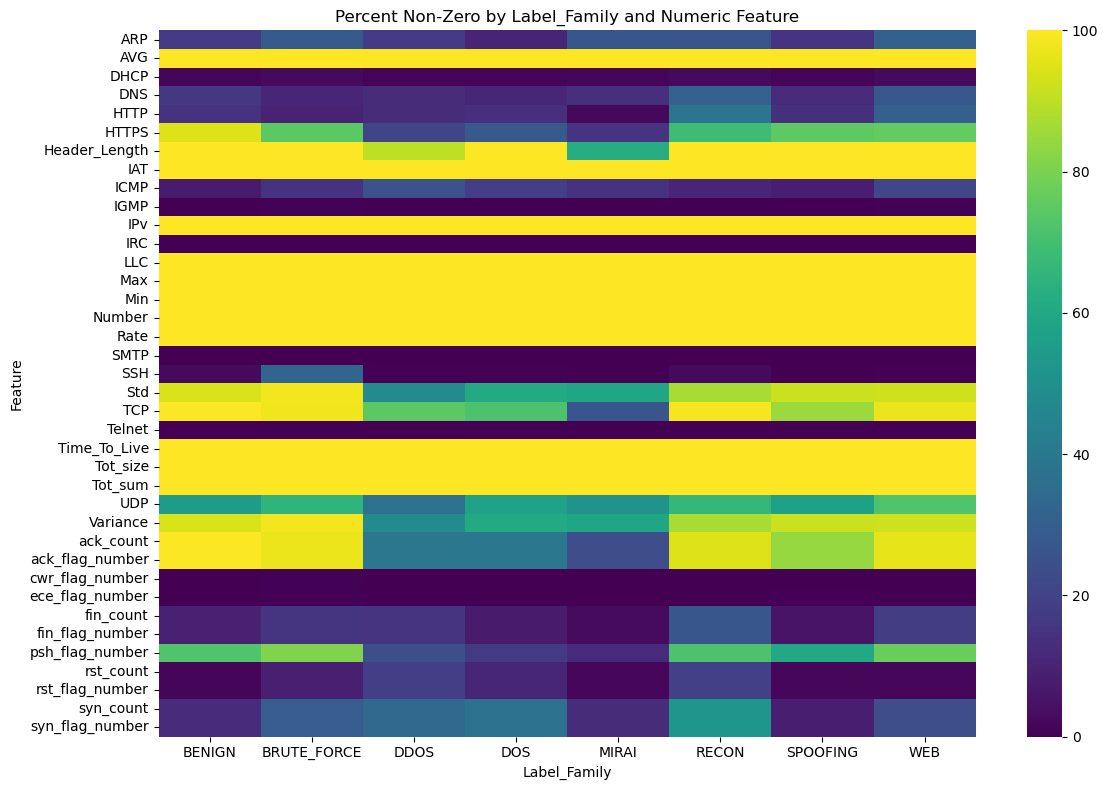

In [42]:
# heatmap visualization of non-zero percentages by label family
family_heatmap_df = pct_nonzero_family_df.pivot(
    index="feature",
    columns="Label_Family",
    values="pct_nonzero"
)

plt.figure(figsize=(12, 8))
sns.heatmap(family_heatmap_df, cmap="viridis")
plt.title("Percent Non-Zero by Label_Family and Numeric Feature")
plt.xlabel("Label_Family")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**Percent Non-Zero by Attack Family (`Label_Family`)**

This heatmap summarizes how frequently each numeric feature takes a non-zero value across the eight attack families in the `Label_Family` column. Each cell represents the **activation rate** of a feature within that attack category.

---

**1. Dense Continuous Features Across All Families**

Features such as **`AVG`, `Tot_size`, `Number`, `Rate`, `Tot_sum`, `Min`, `Max`, `Time_To_Live`, `Header_Length`** are non-zero in nearly all flows for every family.  
These act as **general-purpose traffic descriptors**, providing consistent signal regardless of family type (BENIGN, DDOS, DOS, MIRAI, etc.).

---

**2. Clear Protocol-Level Family Signatures**

Several protocol indicators show family-specific activation patterns:

- **UDP** → Strong in **DDOS**, **MIRAI**, and partially **RECON**  
- **ICMP** → High in **RECON** and **DDOS**  
- **DNS** → Moderate activation in **DDOS** and **WEB**  
- **HTTP/HTTPS** → Higher activation in **WEB** and some **DDOS** variants  

These create **distinct vertical patterns**, helping differentiate high-level attack groups.

---

**3. TCP Counters Reflect High-Level Behavioral Differences**

TCP state features (e.g., `ack_count`, `syn_count`, `fin_count`, `psh_flag_number`) show:

- Elevated activity in **DDOS** and **DOS** families  
- Moderate activation in **MIRAI** due to botnet-oriented TCP scanning  
- Very low usage in **WEB** attacks unless application-layer floods occur  

These offer coarse-grained indicators of transport-layer abuse.

---

**4. Rare-Event Features Remain Low but Informative**

Sparse indicators such as **SSH, IRC, Telnet, IGMP, cwr_flag_number, ece_flag_number** stay near zero across all families except for isolated spikes in:

- **RECON**  
- **MIRAI** (small but noticeable activation for some flags)  

These behave primarily as **binary rare-event signals**, useful when combined with other features.

---

**5. BENIGN vs Attack Family Contrast**

BENIGN flows show:

- High non-zero rates for continuous metrics  
- Very low activation for protocol counters and TCP flags  

Most attack families show the opposite pattern: **low-density continuous descriptors + elevated protocol/flag activity**, creating a clear behavioral separation from benign traffic.

---

**Summary**

The family-level heatmap reveals:

- **Dense metrics** that remain consistent across all traffic  
- **Protocol-specific patterns** that distinguish broad categories of attacks  
- **Transport-level signatures** that separate DDOS/DOS from other families  
- **Sparse rare-event indicators** that highlight reconnaissance or botnet behavior  

These patterns confirm that both continuous and sparse features contribute meaningfully to distinguishing attack families, supporting the value of combining them in downstream modeling.

---

#### 3.1.3 Percent Non-Zero by Label_Binary

In [43]:
pct_nonzero_binary_rows = []

for col in numeric_cols:
    result = (
        scan
        .group_by("Label_Binary")
        .agg([
            (pl.col(col) != 0).sum().alias("nonzero_count"),
            pl.len().alias("total_count"),
        ])
        .with_columns(
            (pl.col("nonzero_count") / pl.col("total_count") * 100.0)
            .alias("pct_nonzero")
        )
        .sort("Label_Binary")
        .collect()
        .to_pandas()
    )

    result["feature"] = col
    pct_nonzero_binary_rows.append(result)

pct_nonzero_binary_df = pd.concat(pct_nonzero_binary_rows, ignore_index=True)

# Keep columns in a nice order
pct_nonzero_binary_df = pct_nonzero_binary_df[
    ["feature", "Label_Binary", "nonzero_count", "total_count", "pct_nonzero"]
]

pct_nonzero_binary_df

,feature,Label_Binary,nonzero_count,total_count,pct_nonzero
0,Header_Length,0,1047232,1047308,99.992743
1,Header_Length,1,17838406,19957932,89.380032
2,Time_To_Live,0,1047232,1047308,99.992743
3,Time_To_Live,1,19957556,19957932,99.998116
4,Rate,0,1047308,1047308,100.000000
...,...,...,...,...,...
71,IAT,1,19957932,19957932,100.000000
72,Number,0,1047308,1047308,100.000000
73,Number,1,19957932,19957932,100.000000
74,Variance,0,987763,1047308,94.314471


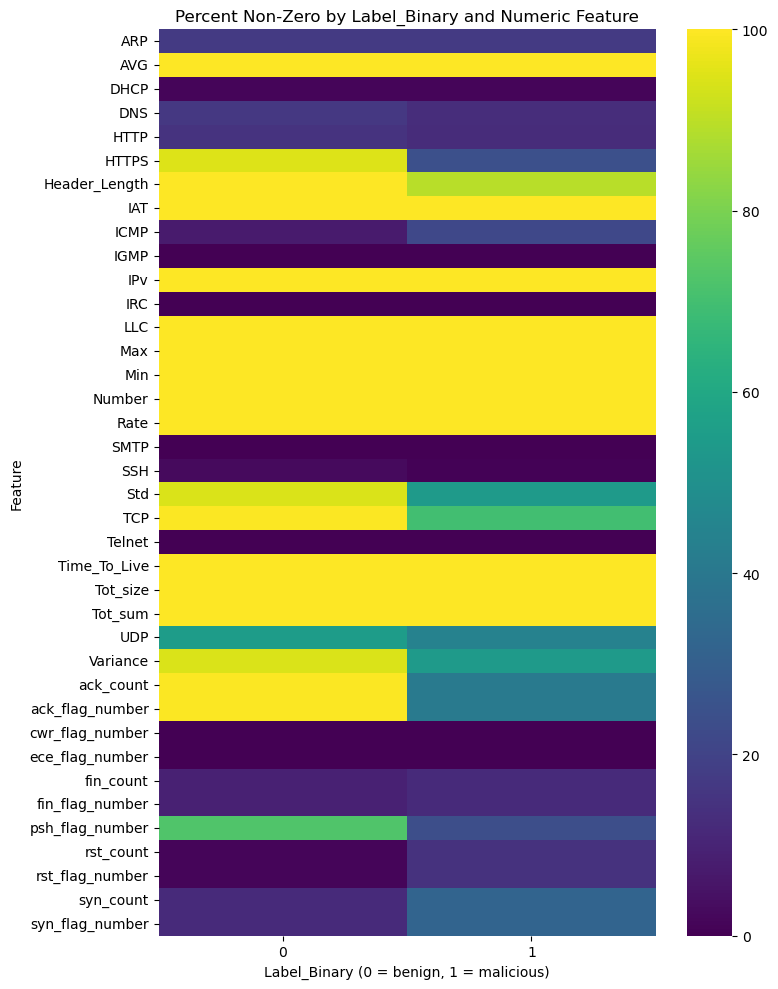

In [44]:
# visualization of non-zero percentages by label binary
binary_heatmap_df = pct_nonzero_binary_df.pivot(
    index="feature",
    columns="Label_Binary",
    values="pct_nonzero"
)

plt.figure(figsize=(8, 10))
sns.heatmap(
    binary_heatmap_df,
    cmap="viridis",
    annot=False
)

plt.title("Percent Non-Zero by Label_Binary and Numeric Feature")
plt.xlabel("Label_Binary (0 = benign, 1 = malicious)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**Percent Non-Zero by Binary Label (`Label_Binary`)**

This heatmap compares the percentage of non-zero values for each numeric feature between **benign (0)** and **malicious (1)** flows. Each row represents a feature’s activation rate, showing how strongly it is used in benign traffic versus attack traffic.

---

**1. Continuous Traffic Features Active in Both Classes**

Metrics such as **`AVG`, `Tot_size`, `Number`, `Rate`, `Tot_sum`, `Min`, `Max`, `Time_To_Live`, `Header_Length`** remain nearly 100% active for both benign and malicious flows.  
These represent **fundamental flow properties** that consistently appear regardless of malicious behavior.

---

**2. Protocol Indicators Increase in Malicious Traffic**

Several protocol-based features show moderate activation in benign flows but noticeably **higher activation in malicious traffic**:

- **ICMP** → spikes in malicious flows  
- **UDP** → higher non-zero rates in attacks  
- **DNS / HTTP / HTTPS** → elevated activity for certain malicious patterns  

These shifts reflect common characteristics of attack behavior such as scanning, flooding, or protocol abuse.

---

**3. TCP Flag Features Strongly Discriminate Malicious Traffic**

TCP-level counters show clear upward shifts from benign → malicious:

- **`syn_count`, `syn_flag_number`**  
- **`ack_count`, `ack_flag_number`**  
- **`psh_flag_number`**  
- **`fin_count`, `rst_count`**

These features rarely activate in benign flows but increase substantially in attacks, making them strong binary discriminators.

---

**4. Rare Features Stay Low but Provide Signal**

Sparse indicators such as **SSH, IRC, Telnet, SMTP, IGMP, cwr_flag_number, ece_flag_number** remain near-zero overall but still show slightly higher activation in malicious samples.  
While individually weak, these features become meaningful when combined with their broader traffic patterns.

---

**Summary**

The binary heatmap highlights a clean separation between benign and malicious behavior:

- **Dense flow metrics** are active in both classes  
- **Protocol indicators** show mild–moderate increases in malicious traffic  
- **TCP flag features** show large activation jumps and serve as strong binary predictors  
- **Rare-event features** stay sparse but contribute auxiliary signal  

These patterns confirm that malicious flows exhibit **distinct activation increases** across protocol usage, packet behavior, and TCP state transitions—providing a strong foundation for downstream binary classification.

---


### 3.2 Distribution Comparison by Labels

This section aims to answer the question: How do the shapes and value distributions of numeric features differ between attack groups?

#### 3.2.1 Boxplots by Label

**Stratified Random Sampling for Boxplots by Label Family**

Boxplots are designed to compare **distribution shapes** across groups. In this analysis, each group corresponds to one of the eight attack families in the `Label_Family` column. Because the dataset is highly imbalanced—some families contain millions of flows while others have only a few thousand—simple random sampling would produce a sample dominated by the largest families.

This causes several issues:

- **Underrepresented families** would contribute too few rows for meaningful boxplots.  
- Small classes would appear to have **artificially low variance** or missing whiskers.  
- Visual comparisons would be distorted by the extreme imbalance.  
- The resulting plots would reflect sampling artifacts, not true distributional differences.

To avoid this, we use **stratified random sampling**, drawing an equal (or proportionally adjusted) number of rows from each attack family. This ensures:

- Every family is **fairly represented** in the visualization.  
- Boxplots accurately reflect **within-family distribution shapes**.  
- Comparisons across families are **balanced and interpretable**.  
- Smaller families are not overshadowed by large ones.

Stratified sampling provides a clear, truthful view of how numeric features behave across attack families, enabling meaningful distributional comparisons.


Top features for Label boxplots: ['Variance', 'Rate', 'Tot_sum', 'Max', 'Std', 'Tot_size']


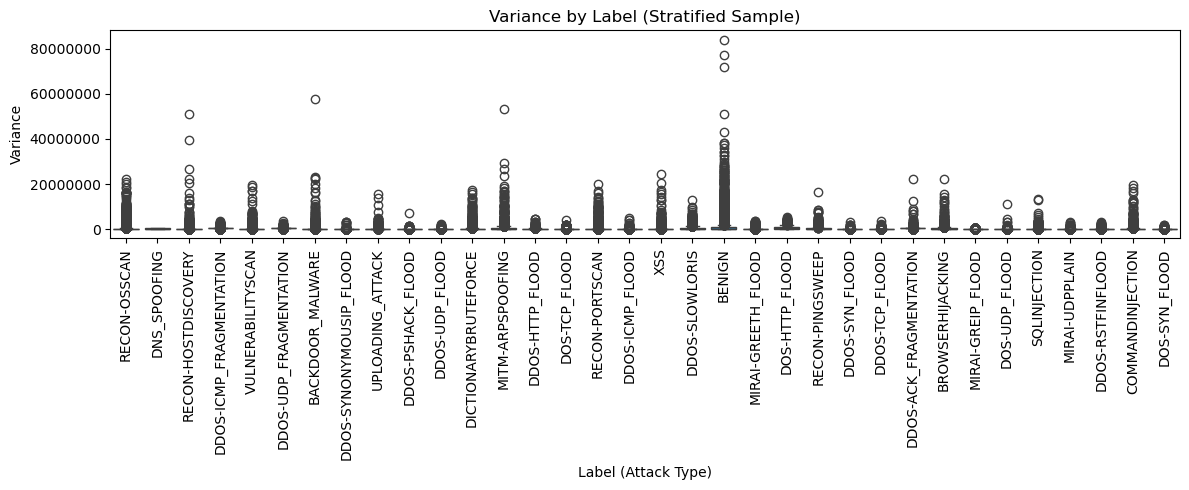

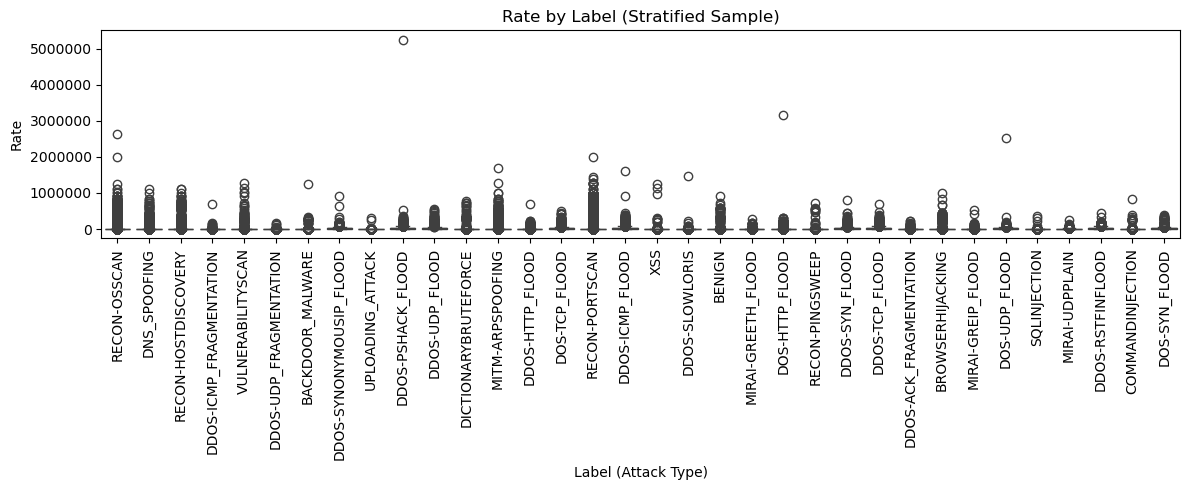

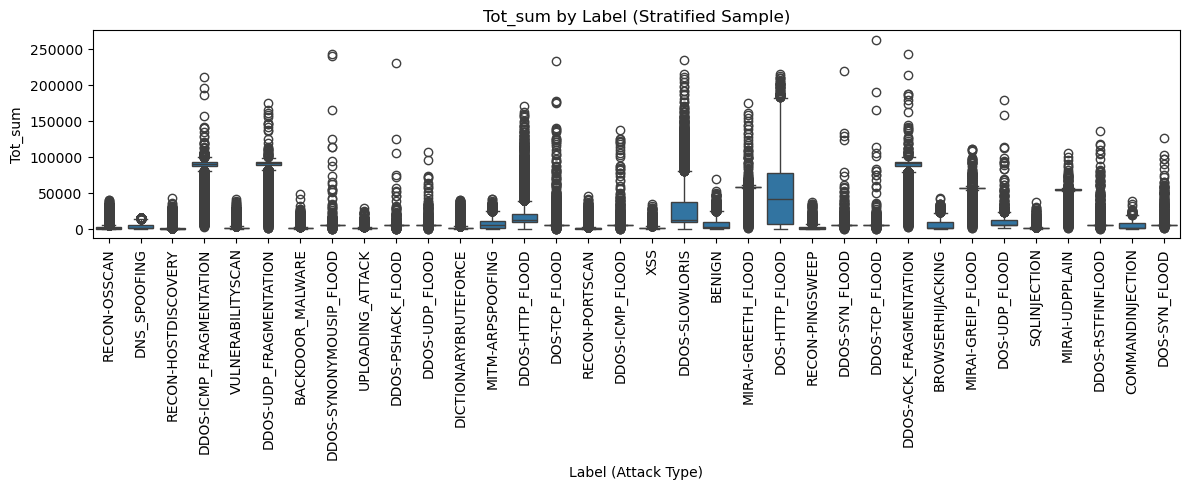

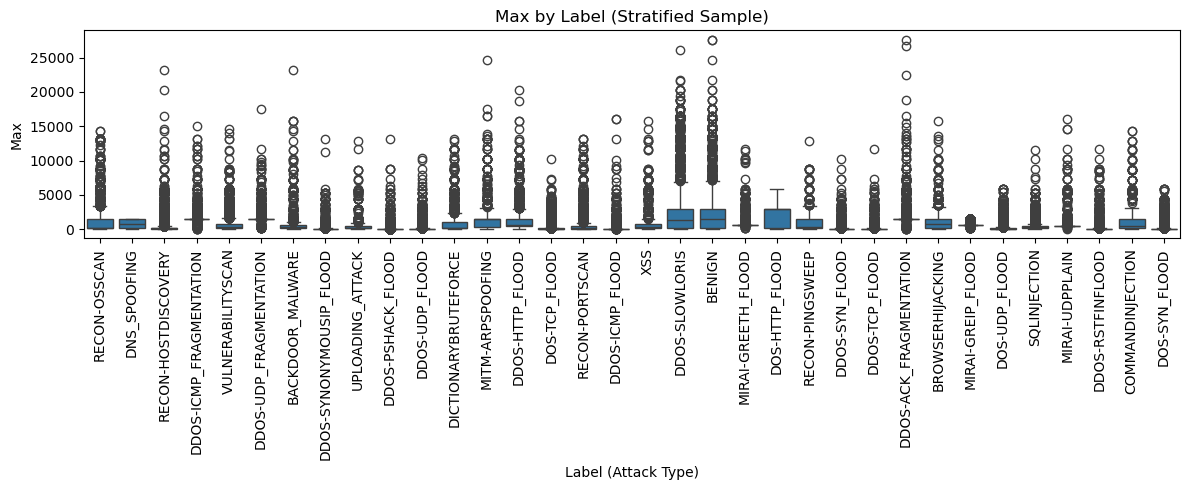

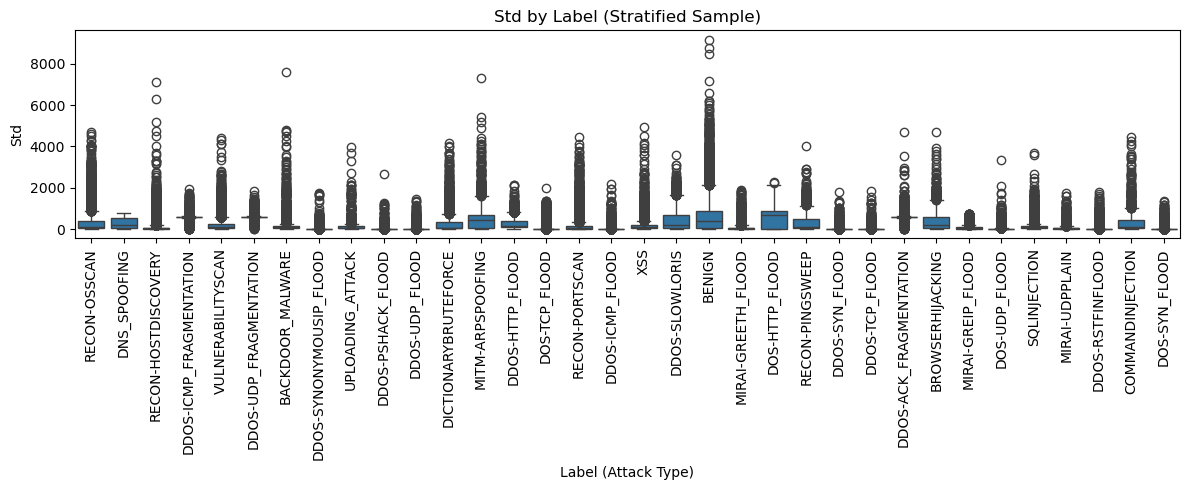

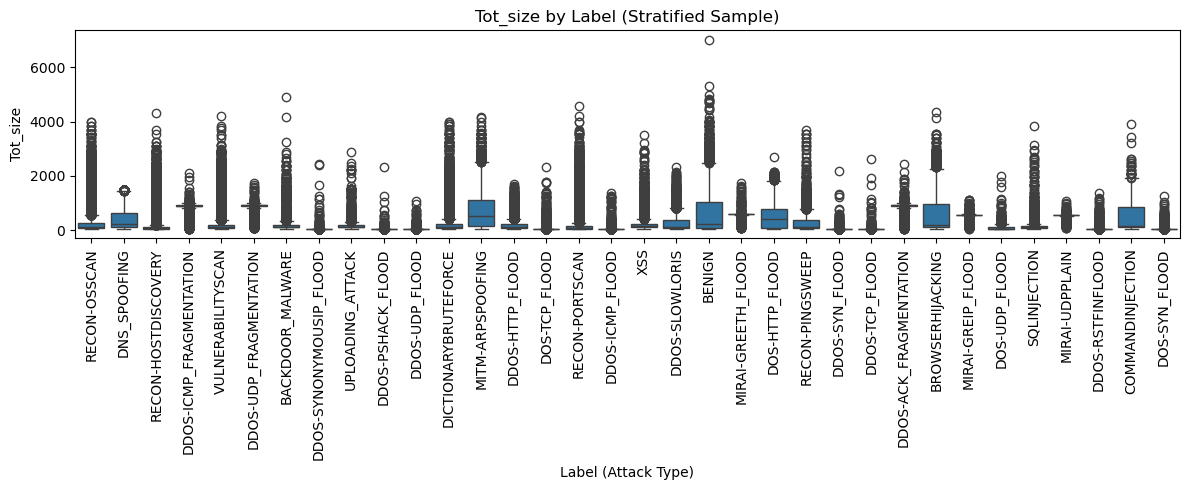

In [45]:
# 1) Pick top features to visualize (e.g., by tail_spread from percentile_df)
TOP_N_FEATURES_LABEL = 6
top_features_label = (
    percentile_df.sort_values("tail_spread", ascending=False)["feature"]
    .head(TOP_N_FEATURES_LABEL)
    .tolist()
)

print("Top features for Label boxplots:", top_features_label)

# 2) Samples per Label
SAMPLE_PER_LABEL = 20_000  # adjust up/down based on performance

# Get counts per Label to avoid oversampling small classes
label_counts_df = (
    scan
    .group_by("Label")
    .agg(pl.len().alias("n_rows"))
    .collect()
    .to_pandas()
)

label_frames = []

for _, row in label_counts_df.iterrows():
    label_value = row["Label"]
    n_rows = int(row["n_rows"])

    # sample at most SAMPLE_PER_LABEL or the available rows
    n_sample = min(SAMPLE_PER_LABEL, n_rows)
    if n_sample == 0:
        continue

    # 3) Filter lazily, then collect, then sample on the materialized DataFrame
    df_label_pl = (
        scan
        .filter(pl.col("Label") == label_value)
        .select(top_features_label + ["Label"])
        .collect()  # materialize to Polars DataFrame
    )

    df_label_sampled = df_label_pl.sample(
        n=n_sample,
        with_replacement=False,
        shuffle=True,
        seed=42,
    )

    label_frames.append(df_label_sampled)

# 4) Combine all labels and convert to pandas for seaborn
if label_frames:
    combined_pl = pl.concat(label_frames)
    boxplot_df = combined_pl.to_pandas()
else:
    boxplot_df = pd.DataFrame(columns=top_features_label + ["Label"])

# Boxplots: each feature vs Label (multiclass)
for col in top_features_label:
    plt.figure(figsize=(12, 5))
    ax = sns.boxplot(data=boxplot_df, x="Label", y=col)
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(style="plain", axis="y")
    plt.title(f"{col} by Label (Stratified Sample)")
    plt.xticks(rotation=90)
    plt.xlabel("Label (Attack Type)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


**Boxplots: Numeric Features vs. Label (Attack Type)**

The stratified-sample boxplots for the top continuous numeric features (`Variance`, `Rate`, `Tot_sum`, `Max`, `Std`, `Tot_size`) reveal several consistent patterns across attack types:

---

**1. Heavy-Tailed Distributions Across All Labels**

All six features show extreme right-skewed distributions, with many attack types containing **large outliers** far above the median.  
This confirms that high-volume or bursty traffic events occur across multiple families of attacks.

---

**2. BENIGN Traffic Shows More Stable, Lower-Variance Behavior**

Benign flows generally have:
- lower medians,  
- narrower IQRs,  
- fewer extreme outliers.  

This distinguishes normal traffic from most attack types, which show more volatility.

---
**3. Flooding Attacks Stand Out with Very High Upper Tails**

Attack types such as:
- **DDOS-UDP_FLOOD**,  
- **DDOS-SLOWLORIS**,  
- **DDOS-SYN_FLOOD**,  
- **DDOS-TCP_FLOOD**,  
- **MIRAI-GREETH_FLOOD**,  

show visibly elevated medians and the largest upper outliers across several features — especially `Variance`, `Rate`, and `Tot_sum`.  
This is consistent with the burst-oriented nature of DDoS traffic.

---

**4. Some Attack Types Show Distinctively Low Activity**

Certain reconnaissance or spoofing attacks (e.g., `RECON-PINGSWEEP`, `DNS_SPOOFING`) exhibit:
- low median packet sizes,  
- narrow spreads,  
- minimal outliers.  

These behaviors differ sharply from volumetric attacks, indicating meaningful feature separation.

---

**5. Feature Separation Varies by Metric**

- `Variance`, `Rate`, and `Tot_sum` show the **clearest separation** between attack classes.  
- `Max`, `Std`, and `Tot_size` also capture differences, but with more overlap.  

These results suggest that **traffic burstiness and aggregate behavior** may be more useful for multiclass classification than simple size-based metrics.

---

**Overall Insight**

The boxplots confirm that different attack types exhibit **distinct statistical profiles**, particularly in terms of burstiness and traffic intensity.  
This separation validates the usefulness of these continuous features for downstream multiclass modeling.



#### 3.2.2 Boxplots by Label_Family

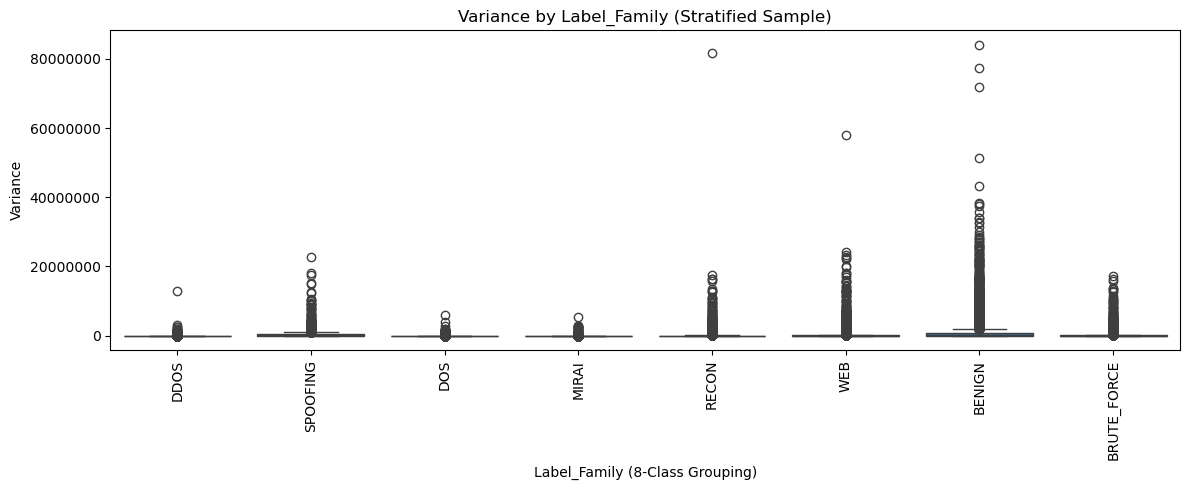

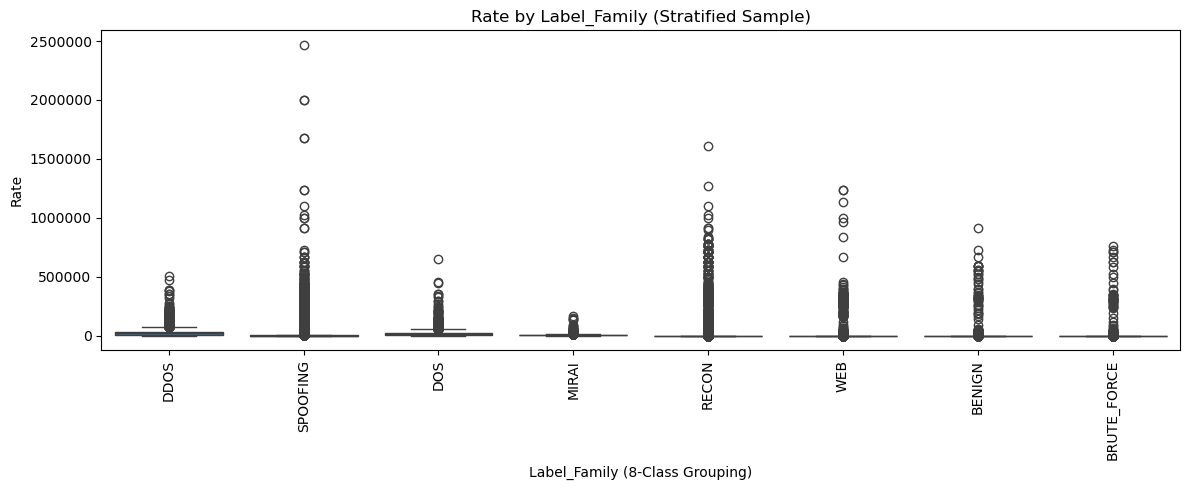

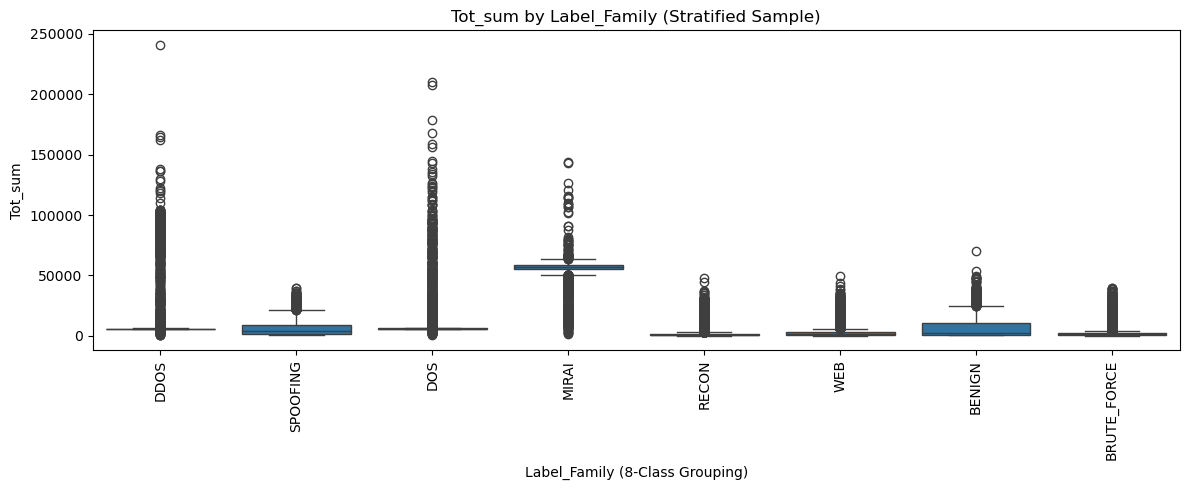

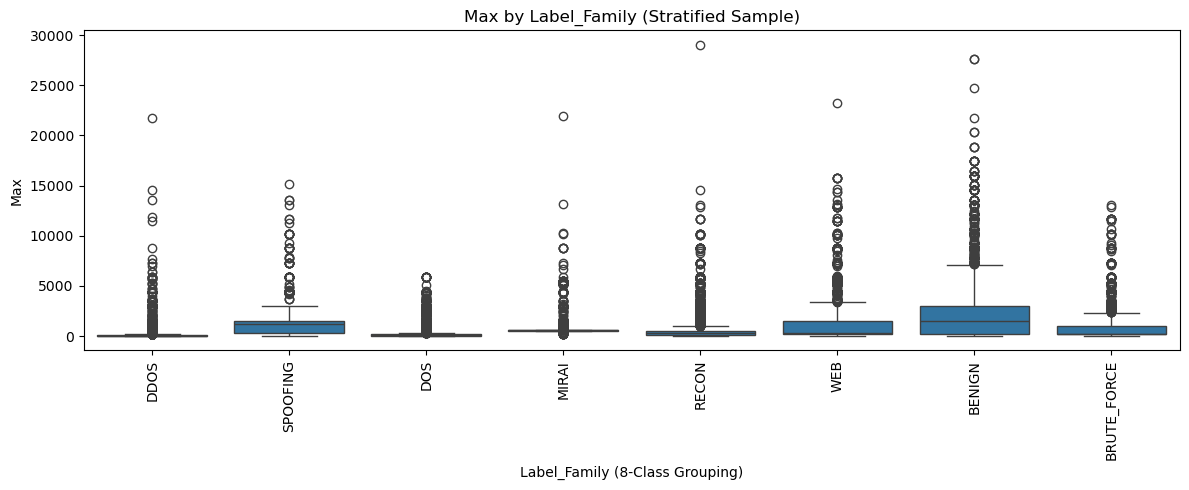

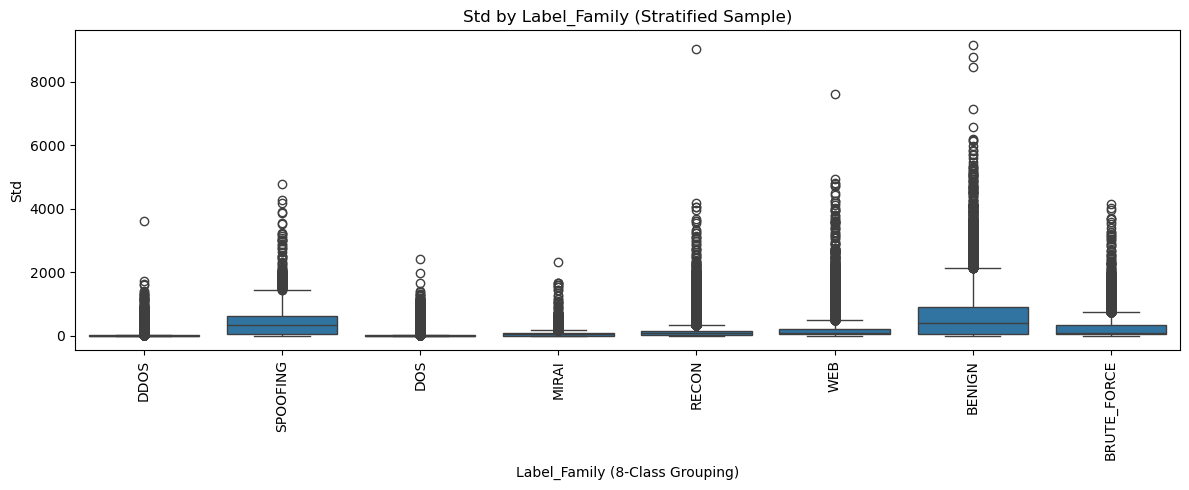

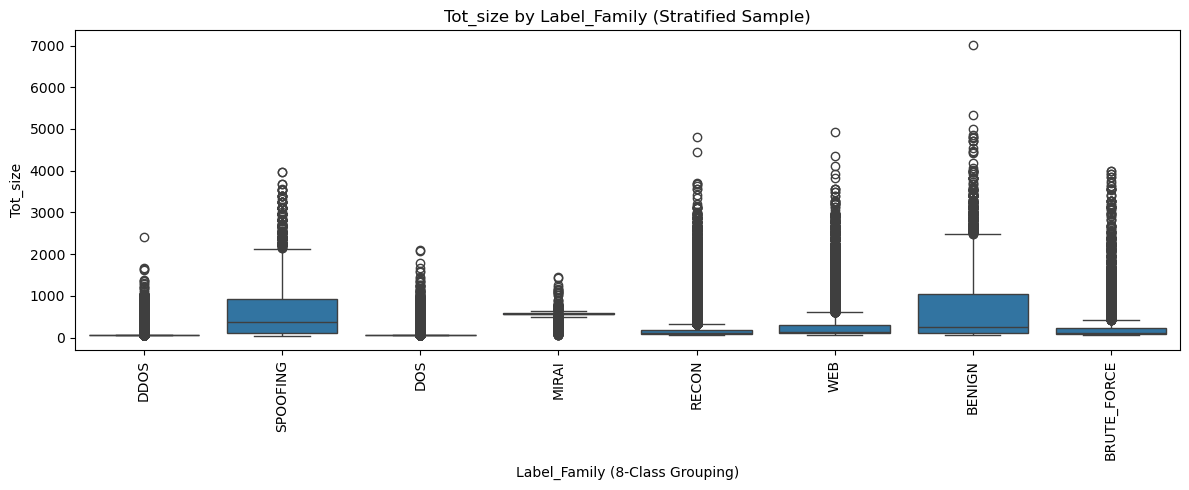

In [49]:
# Reuse the same top features chosen from percentile_df for comparability
top_features_labelfamily = top_features_label

# Reuse the same per-class sample size for consistency
SAMPLE_PER_FAMILY = SAMPLE_PER_LABEL

# 1) Get counts per Label_Family to avoid oversampling small classes
labelfamily_counts_df = (
    scan
    .group_by("Label_Family")
    .agg(pl.len().alias("n_rows"))
    .collect()
    .to_pandas()
)

labelfamily_frames = []

for _, row in labelfamily_counts_df.iterrows():
    family_value = row["Label_Family"]
    n_rows = int(row["n_rows"])

    # Sample at most SAMPLE_PER_FAMILY or the available rows
    n_sample = min(SAMPLE_PER_FAMILY, n_rows)
    if n_sample == 0:
        continue

    # 2) Filter lazily, materialize, then sample on the Polars DataFrame
    df_family_pl = (
        scan
        .filter(pl.col("Label_Family") == family_value)
        .select(top_features_labelfamily + ["Label_Family"])
        .collect()
    )

    df_family_sampled = df_family_pl.sample(
        n=n_sample,
        with_replacement=False,
        shuffle=True,
        seed=42,
    )

    labelfamily_frames.append(df_family_sampled)

# 3) Combine all families and convert to pandas for seaborn
if labelfamily_frames:
    combined_family_pl = pl.concat(labelfamily_frames)
    boxplot_family_df = combined_family_pl.to_pandas()
else:
    boxplot_family_df = pd.DataFrame(columns=top_features_labelfamily + ["Label_Family"])

# 4) Boxplots: each feature vs Label_Family (8-class)
for col in top_features_labelfamily:
    plt.figure(figsize=(12, 5))
    ax = sns.boxplot(data=boxplot_family_df, x="Label_Family", y=col)
    # Turn off scientific notation on the y-axis
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(style="plain", axis="y")
    plt.title(f"{col} by Label_Family (Stratified Sample)")
    plt.xticks(rotation=90)
    plt.xlabel("Label_Family (8-Class Grouping)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

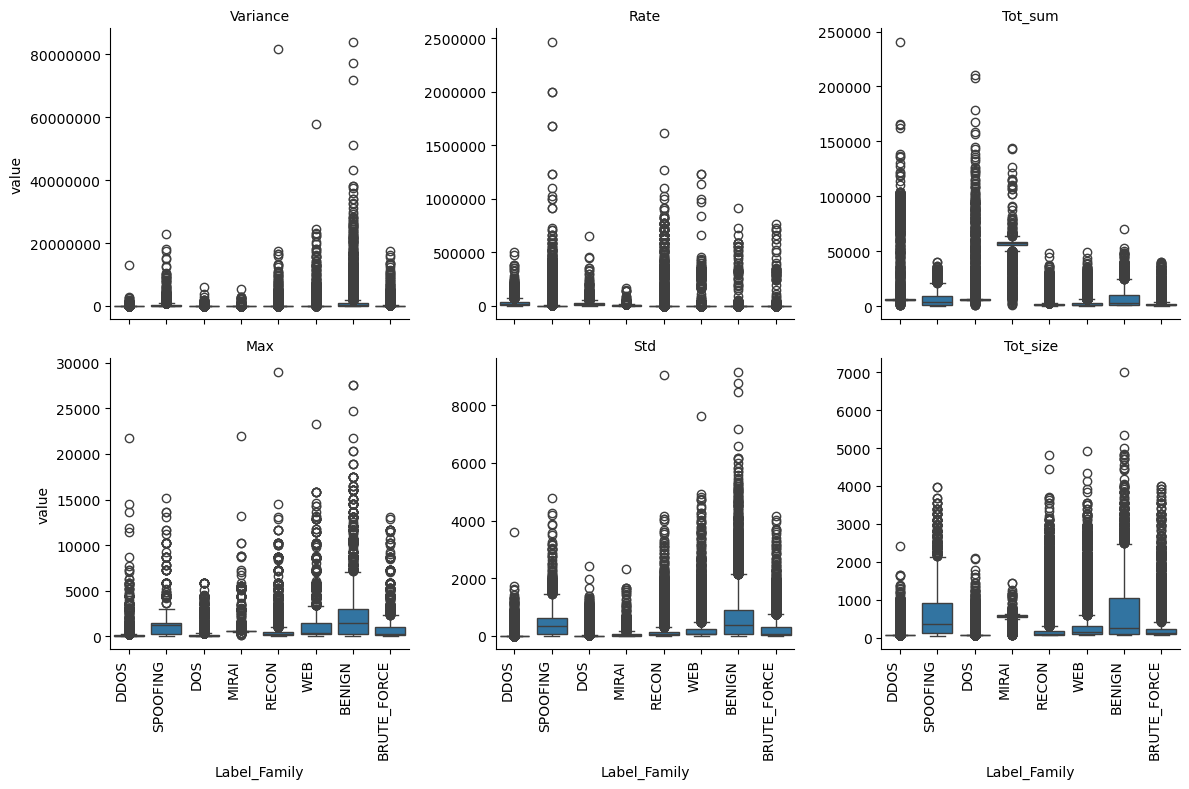

In [57]:
# facetgrid view
family_long = (
    boxplot_family_df
    .melt(
        id_vars="Label_Family",
        value_vars=top_features_labelfamily,
        var_name="feature",
        value_name="value"
    )
)

g = sns.FacetGrid(
    family_long,
    col="feature",
    col_wrap=3,
    sharey=False,
    height=4
)

g.map_dataframe(sns.boxplot, x="Label_Family", y="value")
g.set_axis_labels("Label_Family")
g.set_titles(col_template="{col_name}")
for ax in g.axes.flatten():
    ax.ticklabel_format(style="plain", axis="y")  # avoid scientific notation
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

**Detailed Interpretation of Boxplots by Label_Family (8-Class Grouping)**

The six heavy-tailed numeric features (`Variance`, `Rate`, `Tot_sum`, `Max`, `Std`, `Tot_size`) highlight meaningful behavioral differences across the eight attack families. These patterns help illustrate how each family generates traffic and where major separations from benign behavior occur.

---

**1. BENIGN Traffic**

Benign flows show:
- **Large spreads and many outliers** for *Variance*, *Std*, *Max*, and *Tot_size*.
- **Moderate but not extreme spread** for *Rate* and *Tot_sum*, with distributions that are *much tighter* than DDOS, DOS, or some SPOOFING cases.

This suggests that while benign flows vary widely in packet-level characteristics (e.g., variance, maxima), their overall throughput (*Rate*, *Tot_sum*) is more controlled and doesn’t reach the extreme spikes seen in several attack families.

---

**2. RECON (Scanning Behavior)**

RECON shows:
- Moderate-to-large spread in multiple features, particularly *Rate*, *Max*, and *Std*.
- Numerous high outliers, indicating spikes during probing activity.

This aligns with scanning behavior that produces **irregular bursts** of traffic intensity.

---

**3. WEB Attacks**

WEB attacks exhibit:
- Wider variability than many other attack families.
- Elevated spreads for *Max*, *Variance*, and *Std*.
- Some strong outliers across multiple features.

This pattern is consistent with attacks that involve payload-heavy requests or repeated server interactions.

---

**4. DDOS (Distributed Denial-of-Service)**

DDOS flows display:
- **High medians** and **elevated tails** in *Rate*, *Tot_sum*, *Max*, and *Std*.
- Large, frequent outliers.

This reflects **sustained high-volume flooding**, producing consistently heavy throughput.

---

**5. DOS (Single-Source Denial-of-Service)**

DOS behavior is similar to DDOS but:
- With slightly lower medians.
- Fewer extreme outliers.
- Still significant elevation in heavy-tailed features.

This matches the nature of a single-source flood: **intense but less distributed**.

---

**6. SPOOFING**

SPOOFING traffic shows:
- Lower central tendencies but **frequent large outliers**.
- Noticeable spikes in *Rate*, *Tot_sum*, and *Variance*.

Spoofing often results in **irregular, burst-driven patterns** due to forged identities or packet manipulation.

---

**7. MIRAI**

MIRAI traffic displays:
- Compact distributions with fewer extreme tails.
- Lower variability relative to DDOS/DOS.
- Predictable packet sizes and rates.

This reflects the **uniform, botnet-generated flow patterns** typical of MIRAI.

---

**8. BRUTE_FORCE**

BRUTE_FORCE flows show:
- Small IQRs across most features.
- A handful of moderate outliers.
- Lower median activity.

This aligns with **repetitive, low-volume authentication attempts**, which produce fairly stable traffic.

---

**Overall Interpretation**

- **DDOS, DOS, and SPOOFING** families show the **highest throughput spikes** and largest tails, especially in *Rate*, *Tot_sum*, and *Max*.
- **BENIGN traffic is highly variable**, but *rate-based features are not as extreme* compared to several attack families.
- **RECON and WEB** attacks show mid-to-high variability with intermittent surges.
- **MIRAI and BRUTE_FORCE** are comparatively stable and less bursty.

These distinctions confirm that the selected heavy-tailed features effectively capture **family-level behavioral signatures**, providing strong separation for downstream modeling.


#### 3.2.3 Boxplots by Label_Binary

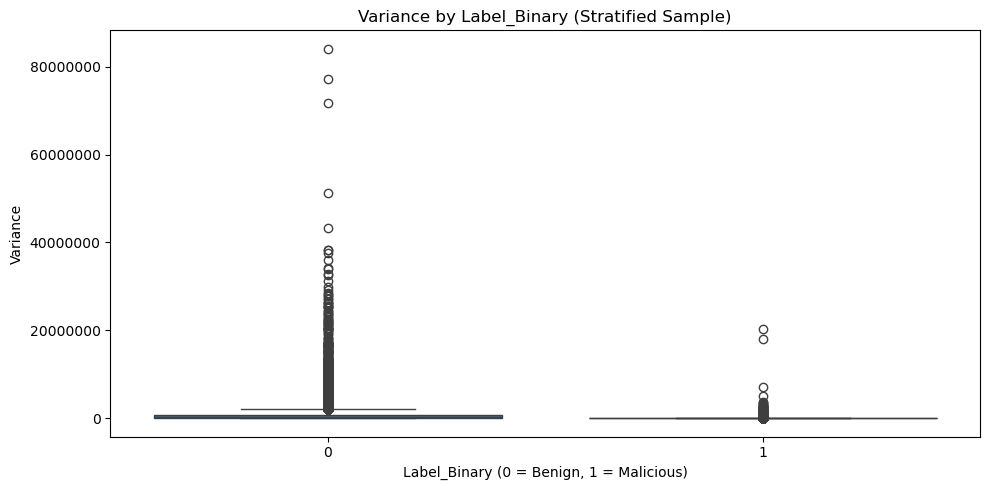

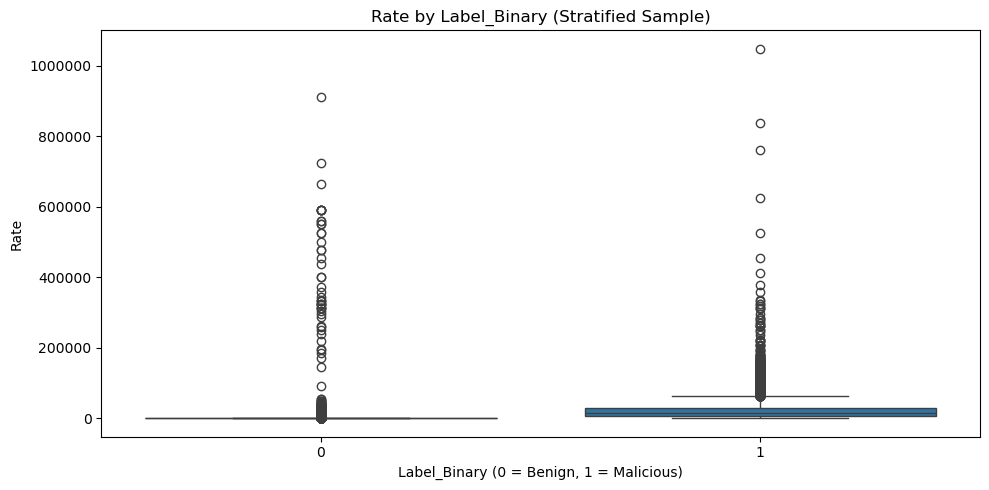

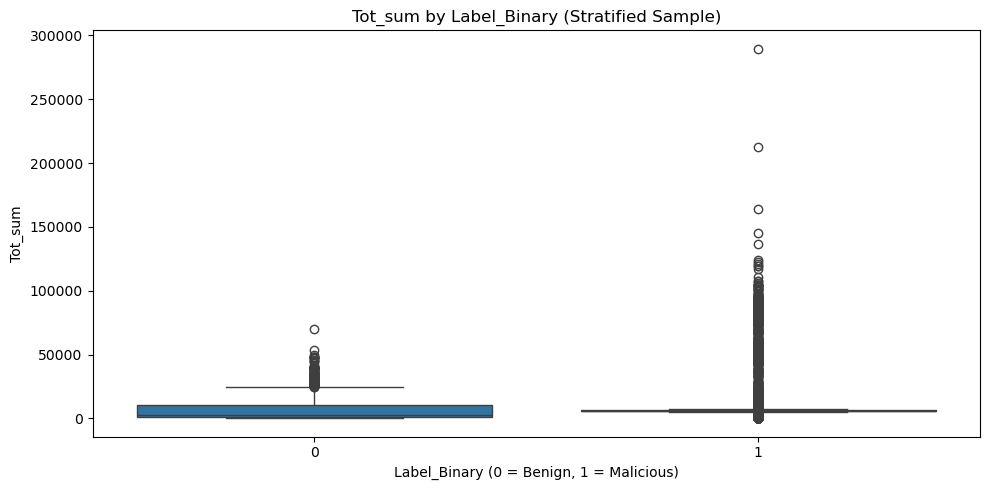

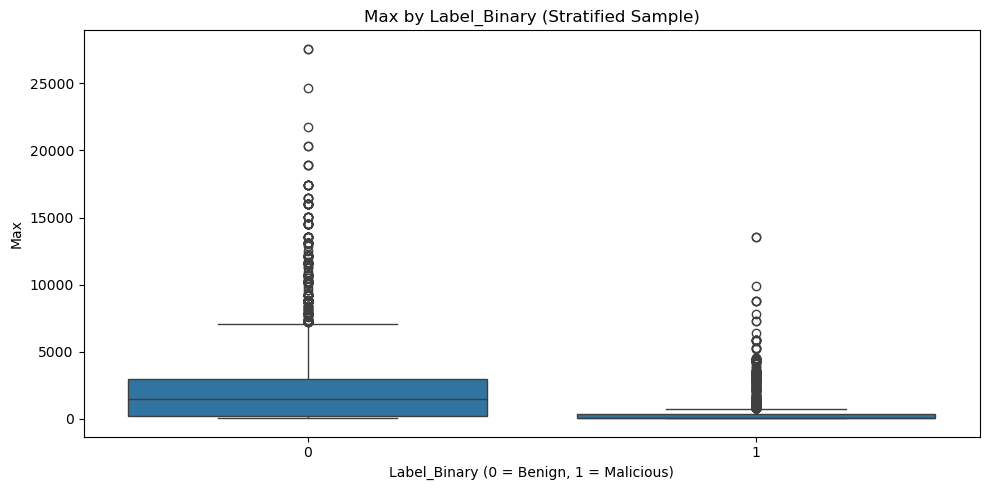

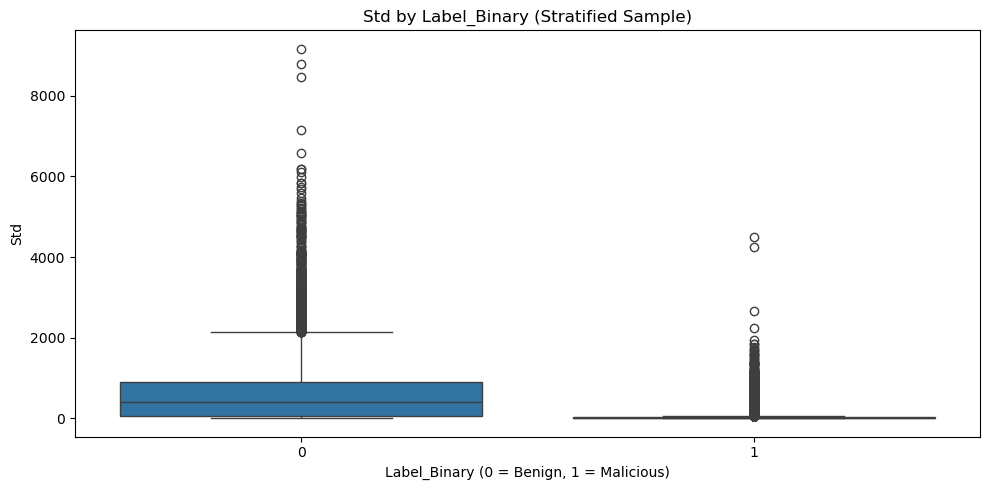

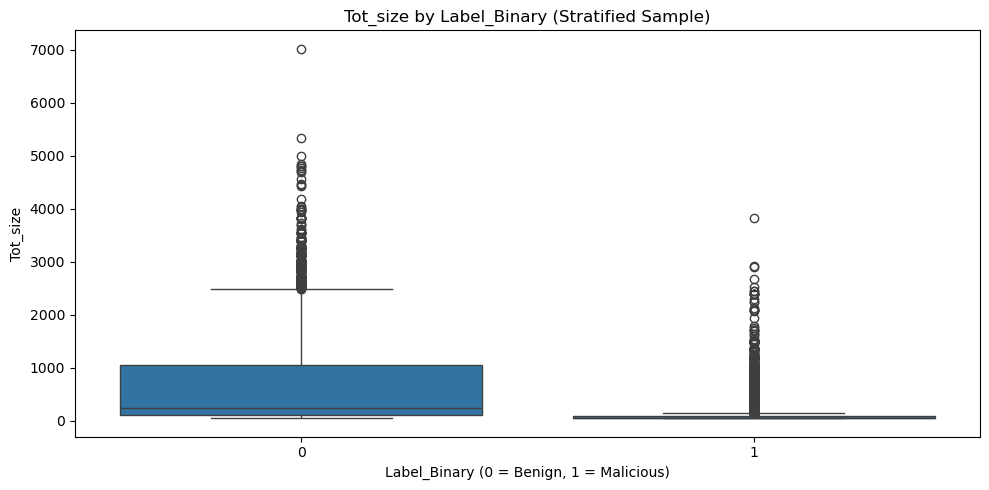

In [50]:
# Reuse the same top features from percentile_df
top_features_binary = top_features_label

# Use the same sample size for consistency
SAMPLE_PER_BINARY = SAMPLE_PER_LABEL

# 1) Get counts for Label_Binary to avoid oversampling
binary_counts_df = (
    scan
    .group_by("Label_Binary")
    .agg(pl.len().alias("n_rows"))
    .collect()
    .to_pandas()
)

binary_frames = []

for _, row in binary_counts_df.iterrows():
    binary_value = row["Label_Binary"]
    n_rows = int(row["n_rows"])

    n_sample = min(SAMPLE_PER_BINARY, n_rows)
    if n_sample == 0:
        continue

    # 2) Filter, materialize, and sample
    df_binary_pl = (
        scan
        .filter(pl.col("Label_Binary") == binary_value)
        .select(top_features_binary + ["Label_Binary"])
        .collect()
    )

    df_binary_sampled = df_binary_pl.sample(
        n=n_sample,
        with_replacement=False,
        shuffle=True,
        seed=42,
    )

    binary_frames.append(df_binary_sampled)

# 3) Combine and convert to pandas
if binary_frames:
    combined_binary_pl = pl.concat(binary_frames)
    boxplot_binary_df = combined_binary_pl.to_pandas()
else:
    boxplot_binary_df = pd.DataFrame(columns=top_features_binary + ["Label_Binary"])

# 4) Boxplots for each feature vs Label_Binary (0 = benign, 1 = malicious)
for col in top_features_binary:
    plt.figure(figsize=(10, 5))
    ax = sns.boxplot(data=boxplot_binary_df, x="Label_Binary", y=col)
    # Disable scientific notation
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(style="plain", axis="y")
    plt.title(f"{col} by Label_Binary (Stratified Sample)")
    plt.xlabel("Label_Binary (0 = Benign, 1 = Malicious)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

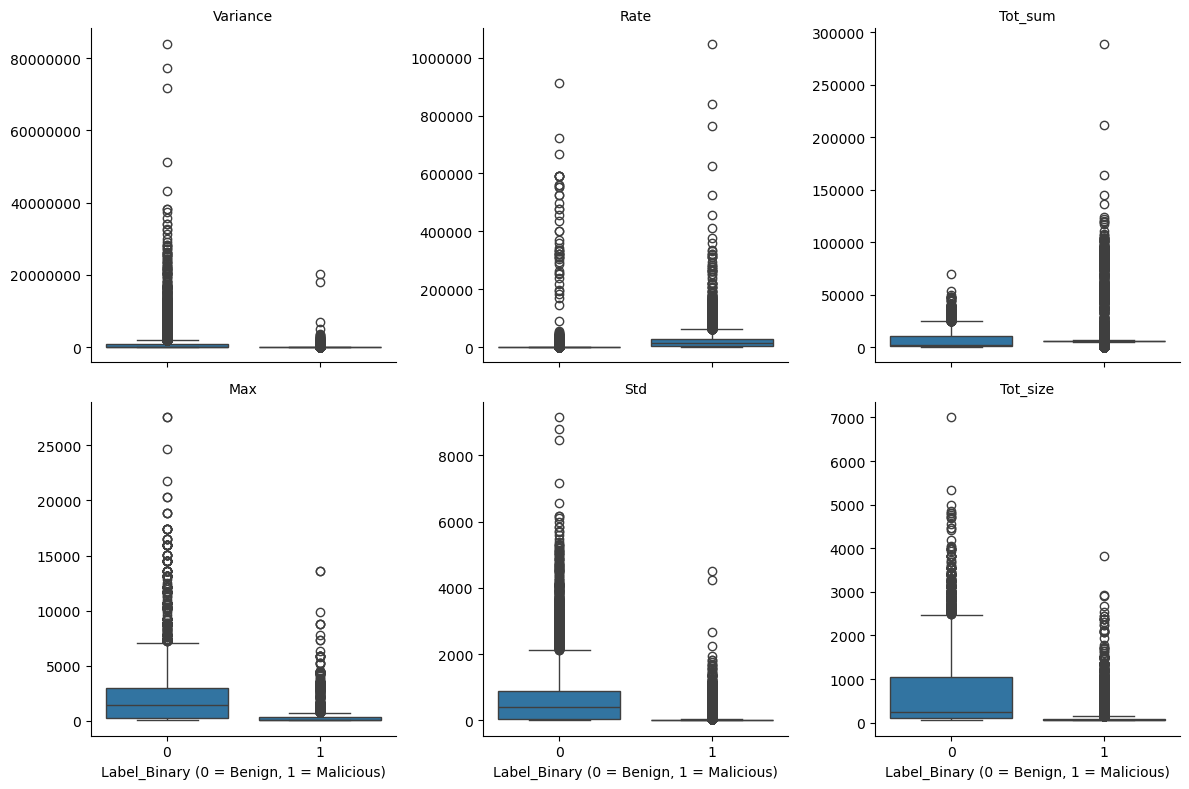

In [ ]:
# facetgrid view
binary_long = (
    boxplot_binary_df
    .melt(
        id_vars="Label_Binary",
        value_vars=top_features_binary,
        var_name="feature",
        value_name="value"
    )
)

g = sns.FacetGrid(
    binary_long,
    col="feature",
    col_wrap=3,
    sharey=False,
    height=4
)

g.map_dataframe(sns.boxplot, x="Label_Binary", y="value")
g.set_axis_labels("Label_Binary (0 = Benign, 1 = Malicious)", "")
g.set_titles(col_template="{col_name}")
for ax in g.axes.flatten():
    ax.ticklabel_format(style="plain", axis="y")  # avoid scientific notation

plt.tight_layout()
plt.show()

**Interpretation of Boxplots by Label_Binary (Benign vs. Malicious)**

The six heavy-tailed features (`Variance`, `Rate`, `Tot_sum`, `Max`, `Std`, `Tot_size`) show clear and meaningful separation between benign (0) and malicious (1) flows, though the direction and magnitude of that separation differ by feature.

---

**1. Benign Traffic (Label_Binary = 0)**

Benign flows exhibit:
- **Much larger spreads** in `Variance`, `Std`, `Max`, and `Tot_size`.
- **Substantial extreme outliers**, especially in `Variance`, suggesting wide behavioral diversity across normal IoT activity.
- **Higher medians** than malicious traffic for features related to packet variability (`Std`, `Variance`) and packet maxima (`Max`).

This indicates that benign traffic is **more volatile and diverse** in its packet-level characteristics, even though it is not necessarily the highest-volume traffic.

---

**2. Malicious Traffic (Label_Binary = 1)**

Malicious flows typically show:
- **Higher medians** in throughput-oriented features (`Rate`, `Tot_sum`), reflecting sustained or bursty activity during attacks.
- **More compact distributions** for variability-related features (`Variance`, `Std`), indicating more uniform or patterned packet behavior.
- **Fewer extreme outliers** than benign traffic in several features, especially `Max` and `Tot_size`.

This suggests that malicious traffic—while often heavier in volume—is **less diverse**, with more consistent behavior patterns driven by scripted or automated attack logic.

---

**3. Key Contrasts Between Benign and Malicious**

- **Volume features (`Rate`, `Tot_sum`) → higher medians for malicious.**  
  Attack traffic tends to push more packets through per flow.

- **Variability features (`Variance`, `Std`, `Max`) → higher dispersion for benign.**  
  Normal behavior shows natural heterogeneity, unlike scripted attack flows.

- **Tail behavior is different between classes.**  
  Benign flows generate the **most extreme outliers**, while malicious flows produce **steadier, more densely clustered distributions**.

---

**Overall Interpretation**

The binary comparison reveals complementary behaviors:

- Malicious flows tend to be **higher-volume but more uniform**, reflecting automated, repetitive attack mechanisms.
- Benign flows are **lower-volume but more diverse**, reflecting natural user/device variability.

These opposing patterns make the selected features highly informative for distinguishing **benign vs. malicious** traffic in downstream classification models.

## 4. Correlation Analysis

In this section, we examine linear relationships among numeric features using the Pearson correlation coefficient. We use the 200,000-row sampled dataset (`sample_df`) created in Section 2.1 to keep  the computation tractable while still capturing the overall structure of the full dataset.

We first compute the full correlation matrix for all numeric features (`numeric_cols`), which will be reused in later subsections (e.g., heatmaps and analysis of highly correlated feature pairs).

### 4.1 Correlation Matrix and Heatmap

Correlation matrix shape: (38, 38)


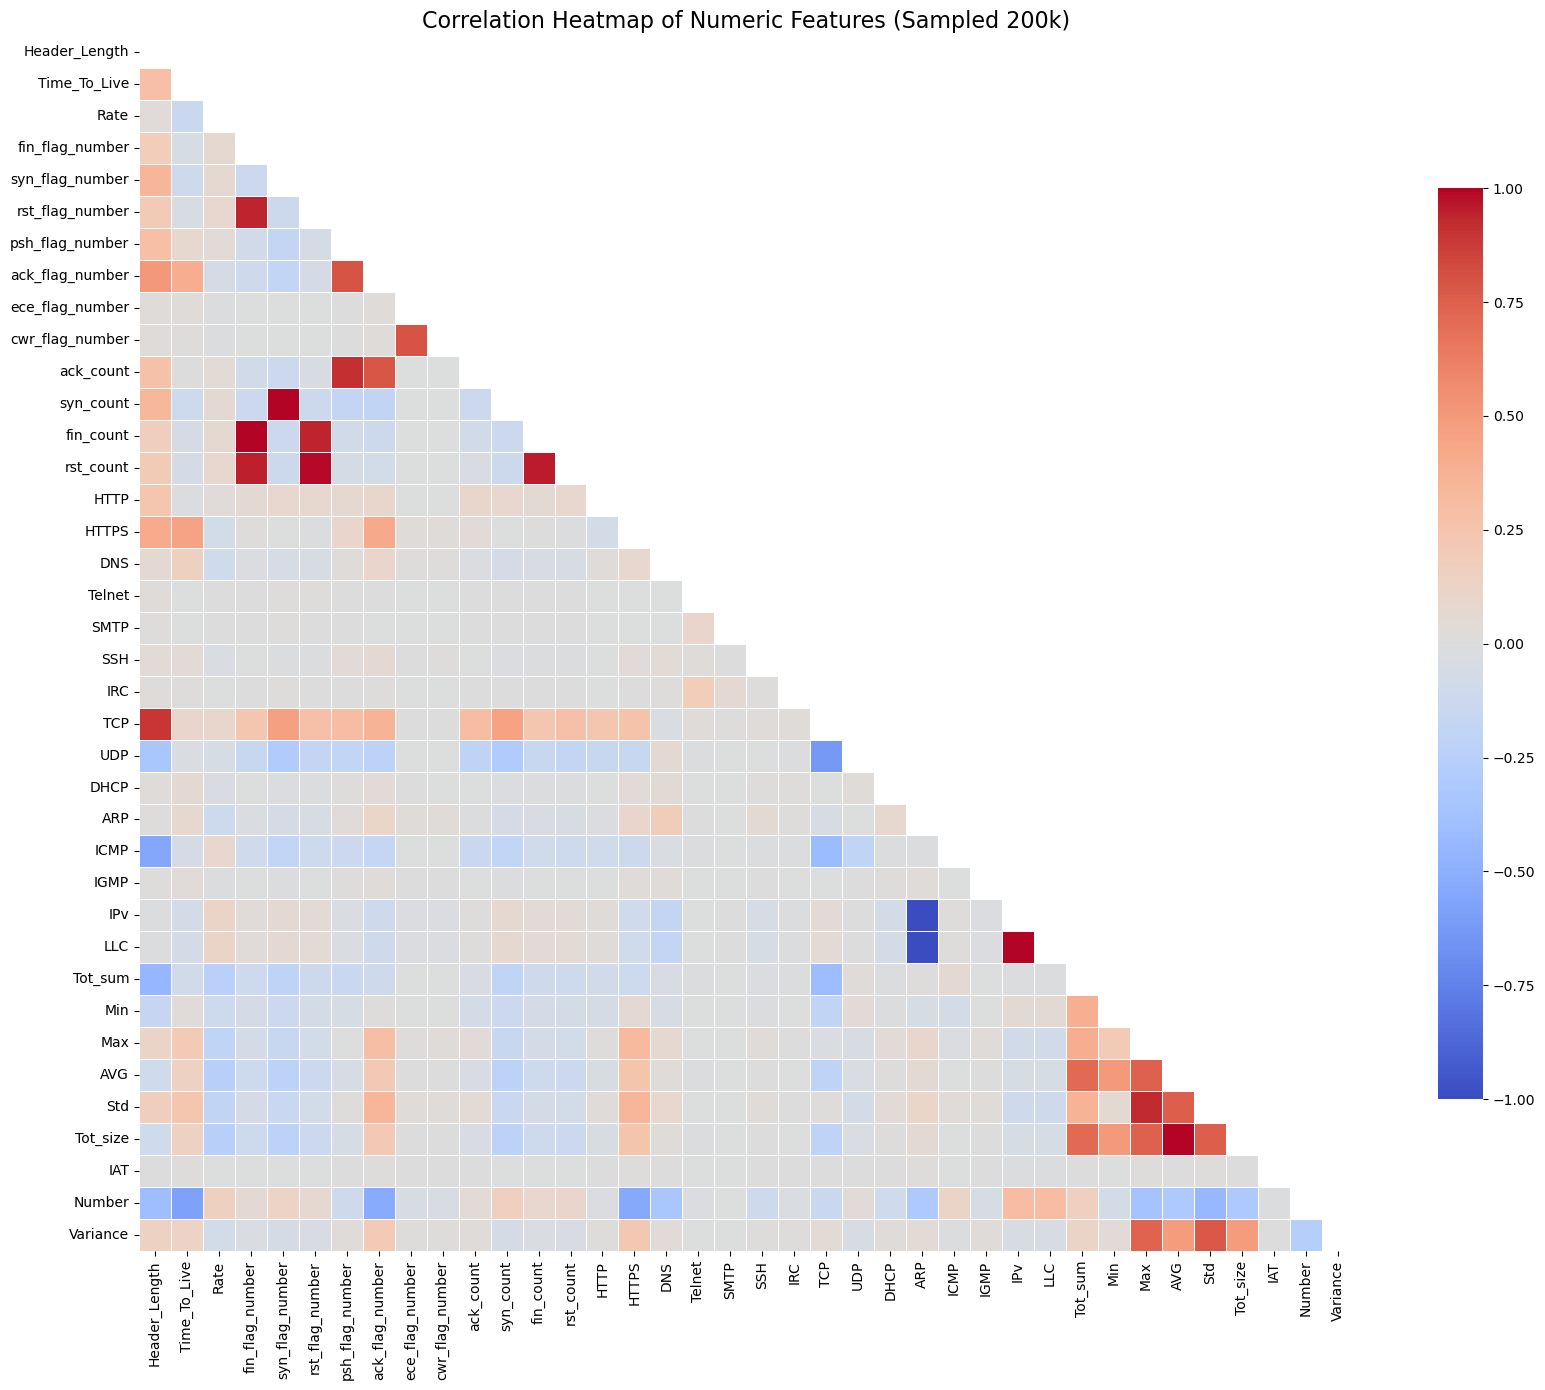

In [ ]:
corr_features = numeric_cols

# Compute Pearson correlation matrix on the sampled data
corr_matrix = sample_df[corr_features].corr(method="pearson")

print("Correlation matrix shape:", corr_matrix.shape)

# create the correlation heatmap
plt.figure(figsize=(18, 14))

# Create mask to hide upper triangle (optional but cleaner)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
)

plt.title("Correlation Heatmap of Numeric Features (Sampled 200k)", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [63]:
# identify the top correlated feature pairs, both negative and positive
corr_pairs = (
    corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "corr"})
)

# Sort by absolute correlation strength, descending
corr_pairs = corr_pairs.reindex(
    corr_pairs["corr"].abs().sort_values(ascending=False).index
)

# Show the top 20 most strongly correlated feature pairs
corr_pairs.head(20)

,feature_1,feature_2,corr
405,LLC,IPv,1.000000
593,Tot_size,AVG,1.000000
375,IPv,ARP,-1.000000
402,LLC,ARP,-1.000000
69,fin_count,fin_flag_number,0.997533
59,syn_count,syn_flag_number,0.993213
83,rst_count,rst_flag_number,0.989557
90,rst_count,fin_count,0.954780
81,rst_count,fin_flag_number,0.951638
71,fin_count,rst_flag_number,0.942934


**Interpretation of the Correlation Matrix and Heatmap**

The correlation heatmap reveals several important structural patterns in the CIC-IoT2023 numeric feature space. Because nearly all features in this dataset are  continuous-valued quantities—many representing *fractions* or *ratios* of packets using specific protocols. The observed correlations primarily reflect **traffic composition**, **transport-layer flagbehavior**, and **flow-size characteristics**, rather than one-hot encoded variables or binary indicator artifacts. 

Below is a summary of the most important correlation clusters and what they imply for downstream modeling.

---

**1. Protocol-Ratio Correlations (IPv, ARP, LLC)**

The highest absolute correlations occur among:

- `LLC` and `IPv` (**+1.00**)  
- `IPv` and `ARP` (**–1.00**)  
- `LLC` and `ARP` (**–1.00**)  

These features measure the **fraction of packets** in a flow using each protocol type. The strong positive/negative correlations indicate that:

- Flows dominated by IPv traffic contain very little ARP traffic.
- Flows containing ARP packets have negligible IPv presence.
- LLC traffic tends to co-occur specifically in IPv-heavy flows.

This reflects **mutually exclusive protocol behaviors** in the dataset's IoT traffic, where certain flows are almost entirely IPv-based while others exhibit ARP  or LLC characteristics. These are not binary one-hot encodings, but they behave similarly due to protocol exclusivity in typical IoT communication patterns.

**Modeling implication:** Only one of these protocol-ratio features may be needed in
linear models to avoid multicollinearity; tree-based models can keep all three.

---

**2. Packet Size and Flow Volume Cluster (Tot_size, AVG, Max, Std, Variance)**

Several packet-size–related features form a tight cluster:

- `Tot_size` ↔ `AVG` (**+1.00**)  
- `Std` ↔ `Max` (**+0.92**)  
- `Variance` ↔ `Std` (**+0.78**)  
- `Tot_size` ↔ `Std` (**+0.75**)  

These features all describe **flow magnitude and packet size distribution**, reflecting how large, variable, and bursty a flow is. Because many packet-size metrics are mathematically linked (e.g., totals, averages, variance), strong correlations are expected.

**Modeling implication:** These variables carry similar information; dimensionality reduction or selective retention may improve model stability.

---

**3. TCP Flag Behavior and Flag Counts**

Strong correlations appear between TCP flag ratios and their corresponding packet counts:

- `fin_count` ↔ `fin_flag_number` (**+0.998**)  
- `syn_count` ↔ `syn_flag_number` (**+0.993**)  
- `rst_count` ↔ `rst_flag_number` (**+0.990**)  

Since the *_flag_number* features represent the **proportion of packets** carrying the flag, and the *_count* features represent the **raw number of packets** with that flag, flows with many SYN/FIN/RST packets naturally show both high counts and high ratios.

Additional correlations among FIN/RST/SYN features (0.94–0.96) indicate that certain attack behaviors—particularly scanning and session teardown anomalies—produce multiple flag types simultaneously.

**Modeling implication:** These features describe related transport-layer patterns; we may retain a subset to reduce redundancy in linear models.

---

**4. ACK/PSH Co-Occurrence**

Moderately strong correlations include:

- `ack_count` ↔ `psh_flag_number` (**+0.91**)  
- `ack_flag_number` ↔ `psh_flag_number` (**+0.80**)  

This reflects common traffic behaviors where ACK and PSH flags co-occur during interactive communication or certain malicious behaviors (e.g., botnet command-and-control traffic).

**Modeling implication:** These correlations encode meaningful behavioral patterns and should be preserved unless strict feature orthogonality is required.

---

**5. Transport Protocol Ratios (TCP, UDP) and Header Characteristics**

A notable correlation:

- `TCP` ↔ `Header_Length` (**+0.897**)

Flows dominated by TCP packets tend to exhibit consistent header length patterns, while flows dominated by other protocols (e.g., UDP or ICMP) differ. This captures useful structure tied to IoT device behavior.

**Modeling implication:** This correlation reflects real protocol-structure interplay,
not redundancy; both features are informative.

---

**Overall Summary**

The correlation matrix shows:

- Several **highly redundant feature groups** driven by mathematical relationships (e.g., volume and size statistics).
- Strong **protocol mixture patterns** where certain protocol ratios are nearly mutually exclusive in IoT traffic.
- Transport-layer **flag-behavior clusters** that encode meaningful malicious vs. benign communication signatures.
- Clear **behavioral structure** in the data, not synthetic artifact correlations.

These observations will guide later steps in feature engineering, multicollinearity assessment, and the selection of features for linear vs. tree-based model families.


### 4.2 Multicollinearity and Feature Redundancy Analysis

The CIC-IoT2023 dataset contains a large number of numeric features describing packet ratios, transport-layer behavior, packet-size statistics, and traffic volume. Many of these features are mathematically or behaviorally related, leading to strong linear dependencies.

This section identifies:

1. Highly correlated feature pairs (|r| ≥ 0.85)
2. Groups of features that form redundant clusters
3. Recommended representative features to retain for modeling

Understanding multi-feature redundancy is essential for:

- Reducing noise and dimensionality
- Preventing multicollinearity issues in linear models
- Improving interpretability
- Streamlining feature engineering decisions

#### 4.2.1 Identification of Highly Correlated Feature Pairs

In [66]:
CORR_THRESHOLD = 0.85

# Use corr_pairs generated in Section 4.1
high_corr_pairs = (
    corr_pairs
    .loc[corr_pairs["corr"].abs() >= CORR_THRESHOLD]
    .sort_values("corr", ascending=False)
    .reset_index(drop=True)
)

print(f"Highly correlated pairs using a threshold of 0.85: {len(high_corr_pairs)}")
high_corr_pairs

Highly correlated pairs using a threshold of 0.85: 14


,feature_1,feature_2,corr
0,LLC,IPv,1.000000
1,Tot_size,AVG,1.000000
2,fin_count,fin_flag_number,0.997533
3,syn_count,syn_flag_number,0.993213
4,rst_count,rst_flag_number,0.989557
5,rst_count,fin_count,0.954780
6,rst_count,fin_flag_number,0.951638
7,fin_count,rst_flag_number,0.942934
8,rst_flag_number,fin_flag_number,0.940617
9,Std,Max,0.923841


#### 4.2.2 Redundancy Clusters Among Highly Correlated Features

In [67]:
from collections import defaultdict, deque

# Build an undirected graph where nodes = features, edges = strong correlations
adjacency = defaultdict(set)

for _, row in high_corr_pairs.iterrows():
    f1, f2 = row["feature_1"], row["feature_2"]
    adjacency[f1].add(f2)
    adjacency[f2].add(f1)

# Find connected components (redundancy clusters)
visited = set()
clusters = []

for feature in adjacency.keys():
    if feature in visited:
        continue
    
    # BFS/DFS to gather all features in this cluster
    queue = [feature]
    visited.add(feature)
    cluster = set()
    
    while queue:
        current = queue.pop()
        cluster.add(current)
        for neighbor in adjacency[current]:
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
    
    clusters.append(sorted(cluster))

# Convert clusters into a tidy DataFrame for inspection
cluster_records = []
for idx, cluster in enumerate(clusters, start=1):
    for feat in cluster:
        cluster_records.append({
            "cluster_id": idx,
            "feature": feat,
            "cluster_size": len(cluster),
        })

redundancy_clusters_df = (
    pd.DataFrame(cluster_records)
      .sort_values(["cluster_size", "cluster_id", "feature"],
                   ascending=[False, True, True])
      .reset_index(drop=True)
)

redundancy_clusters_df

,cluster_id,feature,cluster_size
0,3,fin_count,4
1,3,fin_flag_number,4
2,3,rst_count,4
3,3,rst_flag_number,4
4,1,ARP,3
5,1,IPv,3
6,1,LLC,3
7,2,AVG,2
8,2,Tot_size,2
9,4,syn_count,2


**Redundancy Cluster Interpretation**

Using the correlation threshold of |r| ≥ 0.85, we identified several groups of features that form redundancy clusters. Each cluster represents features that measure closely related or overlapping aspects of network behavior. These clusters highlight areas of strong multicollinearity and guide feature selection decisions for later modeling.

**Cluster 1 — Protocol Ratio Cluster (ARP, IPv, LLC)**  
These protocol-ratio features are strongly correlated due to mutually exclusive protocol usage patterns in IoT traffic. Only one is needed for modeling unless protocol mix is directly relevant.

**Cluster 2 — Packet/Flow Size Metrics (AVG, Tot_size)**  
Average packet size and total flow size are mathematically linked and provide redundant information about flow volume. A single representative feature is sufficient.

**Cluster 3 — TCP FIN/RST Behavior (fin_count, fin_flag_number, rst_count, rst_flag_number)**  
Counts and ratios of FIN/RST flags move together due to shared transport-layer termination and reset patterns. These features reflect the same underlying connection behavior and are partially redundant.

**Cluster 4 — TCP SYN Behavior (syn_count, syn_flag_number)**  
SYN count and SYN ratio capture the same handshake activity. Retaining one feature preserves the signal without redundancy.

**Cluster 5 — Packet Size Variability (Max, Std)**  
Maximum packet size and packet-size standard deviation are tightly linked and describe packet length dispersion. One feature is generally adequate.

**Cluster 6 — ACK/PSH Behavioral Patterns (ack_count, psh_flag_number)**  
ACK-heavy flows often exhibit PSH activity, creating dependency between these features. These capture related interactive communication behavior.

**Cluster 7 — Protocol Dominance and Header Properties (TCP, Header_Length)**  
Flows dominated by TCP packets show consistent header lengths. This reflects protocol structure, and both features may be retained unless a simpler feature set is preferred.

Overall, these redundancy clusters reveal meaningful structure within the feature space
and highlight which variables provide unique information versus repeated signals.
